# INTRO
L'obiettivo di questo esercizio è quello di costruire un modello di machine learning in grado di distinguere i clienti frodatori dagli altri.

# DATASET
Il dataset è composto sia da colonne in chiaro che da colonne anonomizzate ed è una fotografia mensile dei clienti.
Di seguito la spiegazione delle colonne:

- *data_rif*: data di fine mese di riferimento
- *userid*: id del cliente
- *age*: età 
- *profession*: professione
- *region*: regione di residenza
- *account_balance*: saldo del conto a fine mese
- *num_trx_cd*: numero di transazioni con carta di debito eseguite nel mese
- *num_trx_cc*: numero di transazioni con carta di credito eseguite nel mese
- *num_trx_cp*: numero di transazioni con carta prepagata eseguite nel mese
- *num_mov_conto*: numero di movimenti di conto corrente nel mese
- *sum_mov_conto_pos*: somma degli importi dei movimenti in ingresso di conto corrente nel mese
- *sum_mov_conto_neg*: somma degli importi dei movimenti in uscita di conto corrente nel mese
- *num_prodotti*: numero di prodotti posseduti dal cliente
- *f2*, *f3*, *f4*, *f5*, *f6*, *f7*: features comportamentali anonimizzate
- *TARGET*: variabile target che indica se il cliente ha commesso una frode nei mesi successivi


# REQUISITI AGGIUNTIVI
- Possibile utilizzare qualunque libreria di ML purchè venga fornita la versione in modo da poter replicare i risultati
- Si preferiscono modelli "white-box" o spiegabili

# lettura dati

#### Importo librerie che mi servono:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from tqdm import tqdm

#### Set opzioni di configurazione pandas:

In [2]:
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.5f}'.format

#### Identifico datatype per singola colonna del data frame:

In [3]:
DTYPES = {
    'data_rif': str,
    'userid': np.int64,
    'age':  np.int64,
    'profession': str,
    'region': str,
    'account_balance': np.float64,
    'num_trx_cd': np.float64,
    'num_trx_cc': np.float64,
    'num_trx_cp': np.float64,
    'num_mov_conto': np.int32,
    'sum_mov_conto_pos': np.int64,
    'sum_mov_conto_neg': np.int64,
    'num_prodotti': np.int64,
    'f2': np.int64,
    'f3': np.int64,
    'f4': np.int64,
    'f5': np.int64,
    'f6': np.float64,
    'f7': np.float64,
    'TARGET': np.int64
}

df = pd.read_csv("../data/frauds_dataset.csv", sep="~", dtype=DTYPES)
df.head()

,data_rif,userid,age,profession,region,account_balance,num_trx_cd,num_trx_cc,num_trx_cp,num_mov_conto,sum_mov_conto_pos,sum_mov_conto_neg,num_prodotti,f2,f3,f4,f5,f6,f7,TARGET
0,2022-07-31,1000510,23,Lavoratore autonomo,TOSCANA,65627.79927,0.00000,0.00000,0.00000,10,3590,-370,2,88,60,8,20,21.14169,0.26837,0
1,2022-07-31,1001511,55,Lavoratore dipendente,BASILICATA,39335.10996,7.00000,0.00000,0.00000,0,0,0,5,97,63,11,82,38.16945,0.67286,1
2,2022-07-31,1001726,23,Lavoratore autonomo,PUGLIA,-37466.82893,148.00000,0.00000,0.00000,2,636,-294,10,90,49,31,71,38.60238,0.12674,0
3,2022-07-31,1002418,43,Studente,VALLE AOSTA,13864.88020,215.00000,0.00000,0.00000,8,1064,-1640,3,99,66,52,57,31.50541,2.08196,1
4,2022-07-31,1002646,26,Studente,LOMBARDIA,-32625.91084,38.00000,56.00000,6.00000,0,0,0,1,115,56,44,28,36.88265,0.21075,0


# analisi dati

- Controllo subito la composizione del data frame e la presenza di null values per colonna:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24987 entries, 0 to 24986
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_rif           24987 non-null  object 
 1   userid             24987 non-null  int64  
 2   age                24987 non-null  int64  
 3   profession         24800 non-null  object 
 4   region             24797 non-null  object 
 5   account_balance    24987 non-null  float64
 6   num_trx_cd         24787 non-null  float64
 7   num_trx_cc         24768 non-null  float64
 8   num_trx_cp         24785 non-null  float64
 9   num_mov_conto      24987 non-null  int32  
 10  sum_mov_conto_pos  24987 non-null  int64  
 11  sum_mov_conto_neg  24987 non-null  int64  
 12  num_prodotti       24987 non-null  int64  
 13  f2                 24987 non-null  int64  
 14  f3                 24987 non-null  int64  
 15  f4                 24987 non-null  int64  
 16  f5                 249

In [5]:
null_values = df.isnull().sum()
null_values_sorted = null_values.sort_values(ascending=False)
print(null_values_sorted)

num_trx_cc           219
num_trx_cp           202
num_trx_cd           200
region               190
profession           187
data_rif               0
f2                     0
f7                     0
f6                     0
f5                     0
f4                     0
f3                     0
sum_mov_conto_pos      0
num_prodotti           0
sum_mov_conto_neg      0
userid                 0
num_mov_conto          0
account_balance        0
age                    0
TARGET                 0
dtype: int64


- Ora elimino le null values presenti all'interno del data frame per le colonne categoriche region e profession:

In [6]:
df = df.dropna(subset=['region', 'profession'])

- Ricontrollo la presenza delle null values nl data frame:

In [7]:
null_values = df.isnull().sum()
null_values_sorted = null_values.sort_values(ascending=False)
print(null_values_sorted)

num_trx_cc           213
num_trx_cd           197
num_trx_cp           195
data_rif               0
num_prodotti           0
f7                     0
f6                     0
f5                     0
f4                     0
f3                     0
f2                     0
sum_mov_conto_pos      0
sum_mov_conto_neg      0
userid                 0
num_mov_conto          0
account_balance        0
region                 0
profession             0
age                    0
TARGET                 0
dtype: int64


- Ora verifico se ci sono osservazioni che presentano null values contemporaneamente nelle tre colonne riguardanti le transazioni:

In [8]:
# Conta le righe con NaN contemporaneamente in tutte e tre le colonne
num_null_observations = df[df[['num_trx_cc', 'num_trx_cd', 'num_trx_cp']].isnull().all(axis=1)].shape[0]
print(num_null_observations)

0


- Non sono presenti clienti che non hanno valori presenti nelle colonne inerenti alle transazioni. Pertanto non eliminerò al momento nessun'altra osservazione.

### Data_Rif:

In [9]:
display("Distribuzione tra data di rifemento e count user per tipo target:", df.groupby(['data_rif', 'TARGET']).size().unstack())

'Distribuzione tra data di rifemento e count user per tipo target:'

TARGET,0,1
data_rif,,
2022-07-31,3536,538
2022-08-31,3521,560
2022-09-30,3540,540
2022-10-31,3570,571
2022-11-30,3604,539
2022-12-31,3542,550


- La distribuzione dei valori è molto omogenea tra le date. Approfondisco l'analisi utilizzando il metodo Chi-Quadro e P-Value:

In [10]:
# Tabella di contingenza
contingenza = df.groupby(['data_rif', 'TARGET']).size().unstack()
# Test chi-quadro
chi2, p, dof, expected = chi2_contingency(contingenza)
print(f"Chi-quadro: {chi2}")
print(f"P-value: {p}")

Chi-quadro: 1.6818079172254339
P-value: 0.8911836341844502


- **Chi-quadro**: 1.68 (basso, indicando poca deviazione rispetto all'indipendenza).
- **P-value**: 0.89 (molto maggiore di 0.05, quindi non possiamo rifiutare l'ipotesi nulla).
- A questo punto procedo con l'eliminazione della colonna dal data frame:

In [11]:
df = df.drop(columns=['data_rif'])

### Age:

In [12]:
# Identifico età minima e massima nella variaile età:
min_value = df["age"].min()
max_value = df["age"].max()
print("Età minima presente:", min_value)
print("Età massima presente:", max_value)

Età minima presente: 21
Età massima presente: 77


- Non saranno eliminate osservazioni sulla base dell'età dei clienti presenti nel data frame in quanto aventi tutti un'età idonea.

<Figure size 1500x600 with 0 Axes>

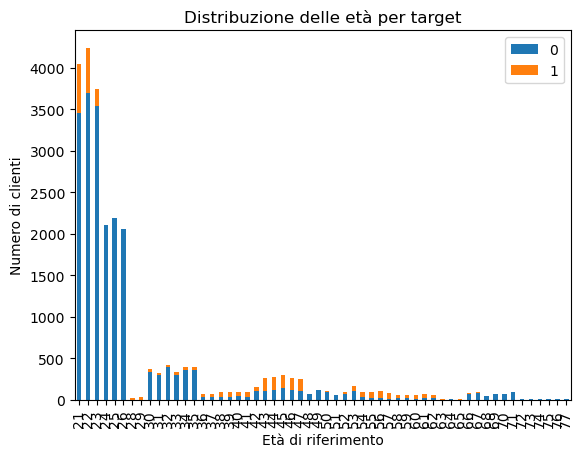

In [13]:
# Identifico la distribuzione delle età per vedere se ci sono outliers:
distribuzione_age = df.groupby(['age', 'TARGET']).size().unstack()
# Visualizza la distribuzione
plt.figure(figsize=(15, 6))
distribuzione_age.plot(kind='bar', stacked=True)
plt.title('Distribuzione delle età per target')
plt.xlabel('Età di riferimento')
plt.ylabel('Numero di clienti')
plt.legend()
plt.show()

- Come posso notare dalla differenza di colorazioni, esistono principalmente utenti fraudolenti nelle fasce d'età comprese tra 20 e 30 anni, così come tra quelle dai 40 ai 50 anni. Motivo per il quale verranno ingegnerizzate nuove colonne per fasce di età corrispondenti.

In [14]:
# Definizione delle fasce di età
bins = [20, 30, 40, 50, 60, 70, float('inf')]
# Etichette delle fasce
labels = ['20-30', '31-40', '41-50', '51-60', '61-70', '70+']  
# Creazione della colonna 'fascia_età'
df['fascia_età'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)
# Creazione delle colonne dummy
dummies = pd.get_dummies(df['fascia_età'], prefix='fascia_età')
# Converti i valori booleani in numerici (1/0)
dummies = dummies.astype(int)
# Aggiunta delle colonne dummy al DataFrame originale
df = pd.concat([df, dummies], axis=1)
# Elimino la colonna fascia di età che non serve più:
df = df.drop(columns=['fascia_età'])

### Profession

In [15]:
print(df["profession"].value_counts())

profession
Studente                 5046
Imprenditore             5003
Lavoratore dipendente    4943
Lavoratore autonomo      4844
Non occupato             4775
Name: count, dtype: int64


- Studenti sono i target più rappresentati. Persone che hanno reddito (Imprenditore, Lavoratore dipendente, Lavoratore autonomo) sono quelle che contano maggior presenze.

<Figure size 1500x600 with 0 Axes>

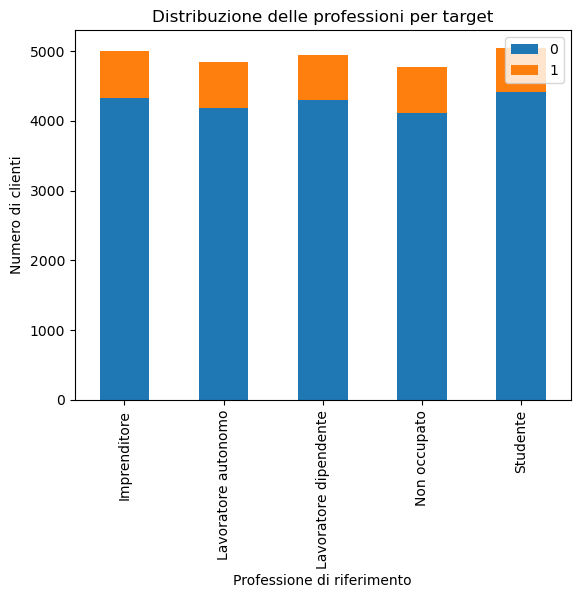

In [16]:
# Identifico la distribuzione delle età per vedere se ci sono outliers:
distribuzione_profession = df.groupby(['profession', 'TARGET']).size().unstack()
# Visualizza la distribuzione
plt.figure(figsize=(15, 6))
distribuzione_profession.plot(kind='bar', stacked=True)
plt.title('Distribuzione delle professioni per target')
plt.xlabel('Professione di riferimento')
plt.ylabel('Numero di clienti')
plt.legend()
plt.show()

- In questo caso la distribuzione delle professioni per tipologia di cliente fraudolento/non fraudolento appare come omogenea. Eseguo la medesima distribuzione tra clienti con o senza reddito creando due variabili dummies in base al tipo di professione:

In [17]:
# Creazione della colonna 'Cliente_Senza_Reddito' se nella colonna profession ricopre un ruolo come studente o non occupato:
df['cliente_senza_reddito'] = df['profession'].isin(['Studente', 'Non occupato']).astype(int)
# Creazione della colonna 'Cliente_Con_Reddito' se nella colonna profession ricopre un ruolo diverso da quelli sopra:
df['cliente_con_reddito'] = df['profession'].isin(['Imprenditore', 'Lavoratore dipendente', 'Lavoratore autonomo']).astype(int)

- Successivamente, eseguo il pre processing della variabile categorica utilizzando one hot encoder con la colonna profession e poi eseguo il drop della colonna originale:

In [18]:
# Instanzio il trasformatore denominato Encoder, in questo caso One-Hot Encoder:
encoder_1 = OneHotEncoder(sparse_output=False, dtype=int)
# Indico quale colonna del mio data frame debba essere encoddata, FasciaOmi:
encoded_columns_1 = encoder_1.fit_transform(df[['profession']])
# Trasformo in un pandas data frame le colonne dummies derivanti dall'encoding:
encoded_df_1 = pd.DataFrame(encoded_columns_1, columns=encoder_1.get_feature_names_out(['profession']), index=df.index, dtype=int)
# Connetto le due df, quella originale dei beni e quella delle variabili dummies insieme:
df = df.join(encoded_df_1)

### Region:
- Creo una nuova colonna che identifica la macro zona geografica del cliente in base alla regione di ubicazione:

In [19]:
regione_to_macro_zona = {'VALLE AOSTA': 'Nord ovest',
                       'LIGURIA': 'Nord ovest',
                       'LOMBARDIA': 'Nord ovest',
                       'PIEMONTE': 'Nord ovest',
                       'TRENTINO-ALTO ADIGE': 'Nord est',
                       'VENETO': 'Nord est',
                       'FRIULI-VENEZIA GIULIA': 'Nord est',
                       'EMILIA-ROMAGNA': 'Nord est',
                       'TOSCANA': 'Centro',
                       'UMBRIA': 'Centro',
                       'MARCHE': 'Centro',
                       'LAZIO': 'Centro',
                       'ABRUZZO': 'Sud',
                       'MOLISE': 'Sud',
                       'CAMPANIA': 'Sud',
                       'PUGLIA': 'Sud',
                       'BASILICATA': 'Sud',
                       'CALABRIA': 'Sud',
                       'SICILIA': 'Isole',
                       'SARDEGNA': 'Isole'}

df['macro_zona_regione'] = df['region'].map(regione_to_macro_zona)

- Eseguo a questo punto la fase di pre processing dei dati sia per la colonna region che per la nuova colonna macro zona:

In [20]:
# Region
encoder_2 = OneHotEncoder(sparse_output=False, dtype=int)
encoded_columns_2 = encoder_2.fit_transform(df[['region']])
encoded_df_2 = pd.DataFrame(encoded_columns_2, columns=encoder_2.get_feature_names_out(['region']), index=df.index, dtype=int)
df = df.join(encoded_df_2)

# Macro zona regione:
encoder_3 = OneHotEncoder(sparse_output=False, dtype=int)
encoded_columns_3 = encoder_3.fit_transform(df[['macro_zona_regione']])
encoded_df_3 = pd.DataFrame(encoded_columns_3, columns=encoder_3.get_feature_names_out(['macro_zona_regione']), index=df.index, dtype=int)
df = df.join(encoded_df_3)

# Elimino la colonna categorica ottenuta:
df = df.drop(columns=['macro_zona_regione'])

### Account_Balance
- Eseguo una distribuzione con rug plot per identificare eventuali outliers nella colonne:

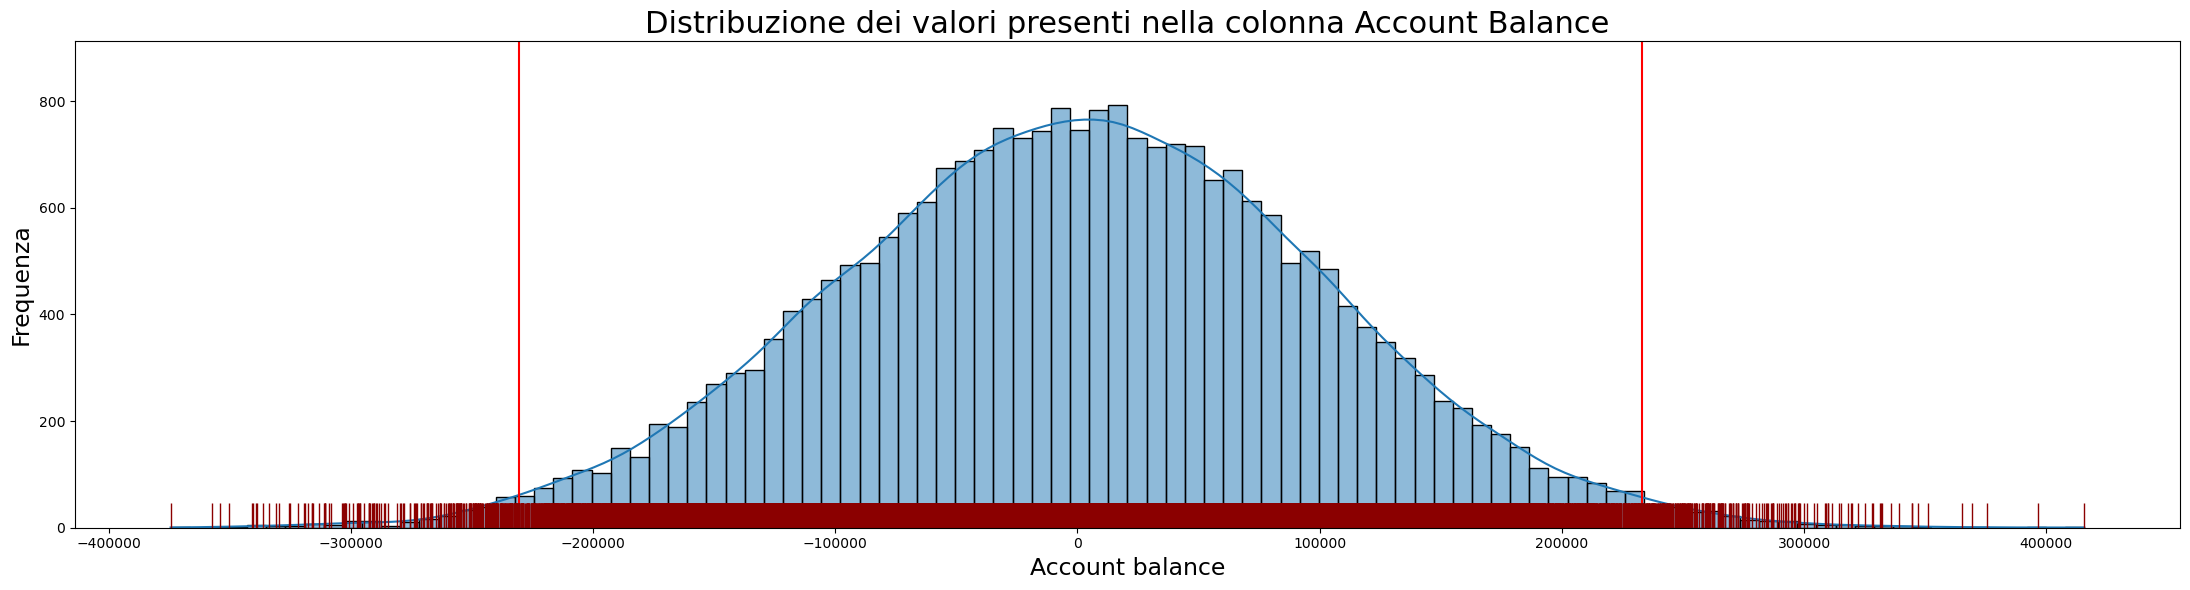

In [21]:
# calcolo i percentili minimi e massimi:
primi_percentili = df['account_balance'].quantile(0.01)
ultimi_percentili = df['account_balance'].quantile(0.99)
# Eseguo il plot:
fig, (ax2) = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='account_balance', bins=100, kde=True, ax=ax2)
ax2.axvline(x=primi_percentili, color='red', linestyle='solid', label='5° percentile')
ax2.axvline(x=ultimi_percentili, color='red', linestyle='solid', label='95° percentile')
sns.rugplot(data=df, x="account_balance", height=.05, color="darkred")
ax2.set_title('Distribuzione dei valori presenti nella colonna Account Balance', fontdict={'fontsize': 22})
ax2.set_xlabel('Account balance', fontsize=17)
ax2.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

- Ora eseguo la distribuzione degli account balance a seconda del target di riferimento:

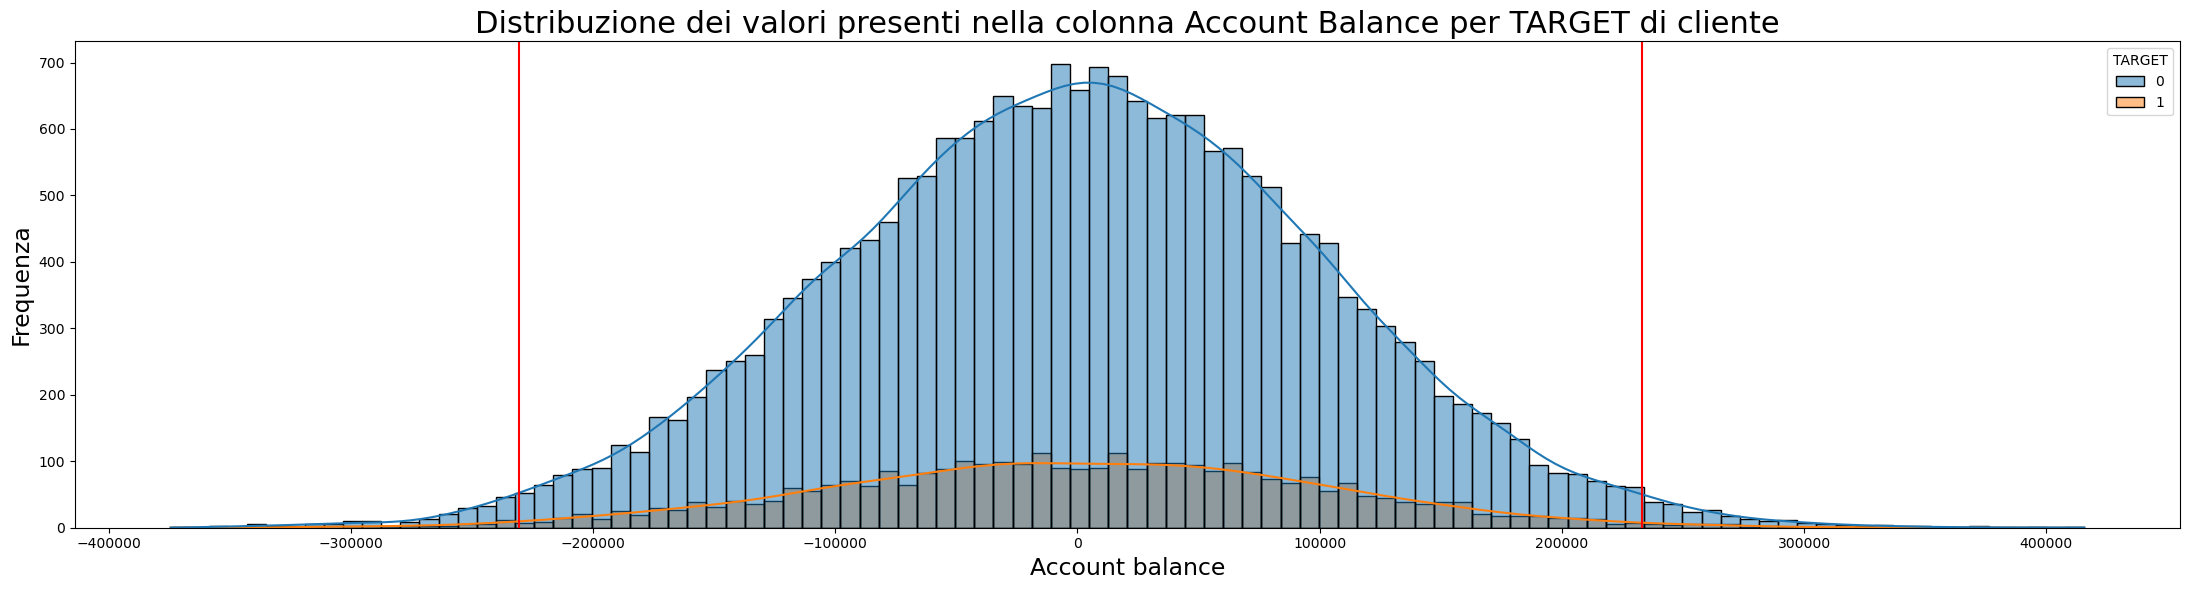

In [22]:
fig, ax = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='account_balance', bins=100, kde=True, hue='TARGET', ax=ax)
ax.axvline(x=primi_percentili, color='red', linestyle='solid', label='5° percentile')
ax.axvline(x=ultimi_percentili, color='red', linestyle='solid', label='95° percentile')
ax.set_title('Distribuzione dei valori presenti nella colonna Account Balance per TARGET di cliente', fontdict={'fontsize': 22})
ax.set_xlabel('Account balance', fontsize=17)
ax.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

- Non si evince una effettiva tendenza per i clienti fraudolenti nell'avere un account balance estremamente alto o basso, pertanto posso procedere con l'eliminazione dei clienti con i saldi più estremi.

In [23]:
df_outliers_account_balance = df[(df['account_balance'] < primi_percentili) | (df['account_balance'] > ultimi_percentili)]
print(f"Sono presenti effettivamente N°: {df_outliers_account_balance.shape[0]} outliers all'interno del data frame, rappresentanti il 1° e il 99° percentile della colonna account_balance.")

Sono presenti effettivamente N°: 494 outliers all'interno del data frame, rappresentanti il 1° e il 99° percentile della colonna account_balance.


In [24]:
df = df[(df['account_balance'] > primi_percentili) & (df['account_balance'] < ultimi_percentili)]
print("Il data frame a questo punto rimane composto da un totale di osservazioni pari a:", df.shape[0])

Il data frame a questo punto rimane composto da un totale di osservazioni pari a: 24117


- Ora creo delle nuove colonne sulla base dei valori riportati nella variabile "account_balance" per identificare lo stato di salute del cliente, se positivo o negativo, o estremamente positivo o negativo, successivamente eseguo il relativo pre processing della nuova colonna account balance macro:

In [25]:
# Trasformo la colonna in integres:
df['account_balance'] = df['account_balance'].astype(int)

# Account_balance_macro:
# Creo le condizioni per poi mappare la nuova colonna:
conditions = [df['account_balance'] <= -100000,
              (df['account_balance'] >= -99999) & (df['account_balance'] <= -1),
              (df['account_balance'] >= 0) & (df['account_balance'] <= 99999),
              df['account_balance'] >= 100000]
# Definizione delle categorie corrispondenti
categories = ['Saldo_Molto_Negativo',
              'Saldo_Negativo',
              'Saldo_Positivo',
              'Saldo_Molto_Positivo']
# Creazione della nuova colonna
df['account_balance_macro'] = np.select(conditions, categories)

# Account_balance_macro pre-processing:
encoder_4 = OneHotEncoder(sparse_output=False, dtype=int)
encoded_columns_4 = encoder_4.fit_transform(df[['account_balance_macro']])
encoded_df_4 = pd.DataFrame(encoded_columns_4, columns=encoder_4.get_feature_names_out(['account_balance_macro']), index=df.index, dtype=int)
df = df.join(encoded_df_4)

### num_trx_cd, num_trx_cc, num_trx_cp:

- Sostituisco le null values ritrovate nelle tre colonne numeriche attraverso una group by multipla di 4 colonne categoriche di riferimento:

In [26]:
# Calcolo delle medie per ogni combinazione di gruppi, per cc - cd- cp:
media_trx_cc = df.groupby(['age', 'profession', 'region', 'account_balance_macro'])['num_trx_cc'].transform('mean')
media_trx_cd = df.groupby(['age', 'profession', 'region', 'account_balance_macro'])['num_trx_cd'].transform('mean')
media_trx_cp = df.groupby(['age', 'profession', 'region', 'account_balance_macro'])['num_trx_cp'].transform('mean')

# Sostituzione dei valori nulli nelle tre colonne menzionat con i valori medi per gruppo ottenuti:
df['num_trx_cc'] = df['num_trx_cc'].fillna(media_trx_cc)
df['num_trx_cd'] = df['num_trx_cd'].fillna(media_trx_cd)
df['num_trx_cp'] = df['num_trx_cp'].fillna(media_trx_cp)

- Creo una nuova colonna basata sulla somma delle tre colonne che identificano il numero di transizioni per CD, CC & CP:

In [27]:
df["num_trx_tot"] = df["num_trx_cd"] + df["num_trx_cc"] + df["num_trx_cp"]

- Dopo aver eseguito la bonifica delle null values, avendo individuato ancora nan nelle colonne transazioni provvedo al loro drop dal data frame:

In [28]:
df = df.dropna(subset=['num_trx_cd']).reset_index(drop=True)
df = df.dropna(subset=['num_trx_cp']).reset_index(drop=True)
df = df.dropna(subset=['num_trx_cc']).reset_index(drop=True)
df = df.dropna(subset=['num_trx_tot']).reset_index(drop=True)

- Plotto la distribuzione visualizzando ventuali outliers per quanto riguarda il numero di transazioni totali effettuati per cliente:

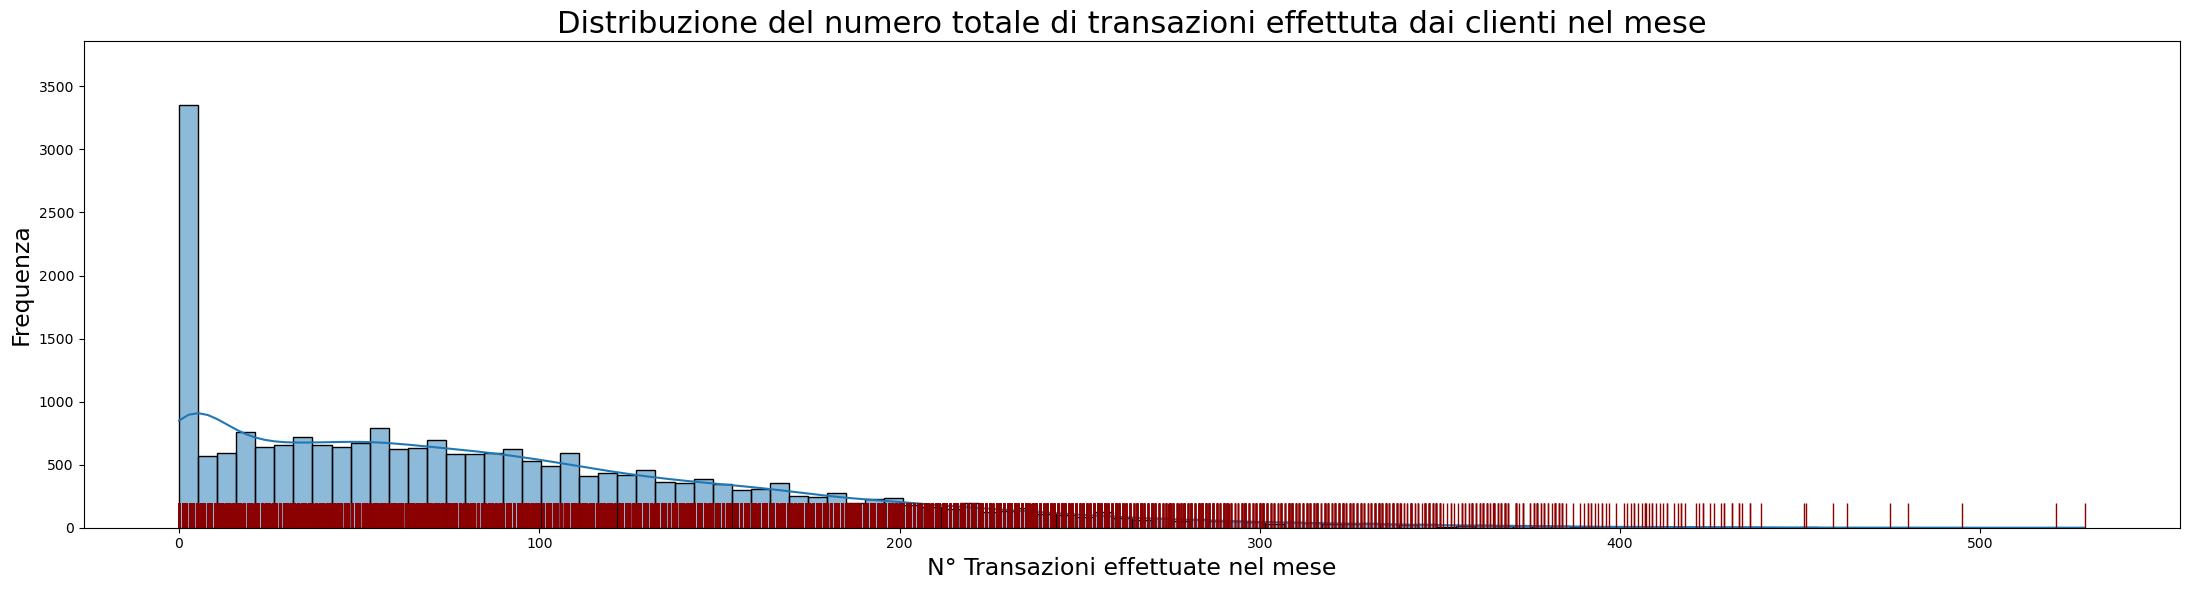

In [29]:
fig, (ax2) = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='num_trx_tot', bins=100, kde=True, ax=ax2)
sns.rugplot(data=df, x="num_trx_tot", height=.05, color="darkred")
ax2.set_title('Distribuzione del numero totale di transazioni effettuta dai clienti nel mese', fontdict={'fontsize': 22})
ax2.set_xlabel('N° Transazioni effettuate nel mese', fontsize=17)
ax2.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

- Attraverso questa visualizzazione posso innanzitutto affermare che ci sono numerosi clienti che effettuano zero transazioni durante il mese, quindi creerò una colonna denominata "Clienti_Inattivi" per coloro che non hanno transazioni. Inoltre, posso appurare che ci sono una manciata di clienti che eseguono una quantità molto elevata di transazioni durante il mese, ovvero oltre le 400 volte, creando quindi un' ulteriore colonna "Cliente_Sospetto" per tutti quei clienti con un numero superiore o uguale a 400 transazioni totali effettuate durante il mese.

In [30]:
# Creo colonna booleana per identificare i clienti che non hanno transazioni sul proprio conto nell'ultimo mese:
df['transazioni_assenti'] = (df['num_trx_tot'] == 0).astype(int)

# Eseguo con la stessa logica altre tre colonne che identificano se una delle tre carte non ha avuto transazioni:
df['zero_trx_cc'] = (df['num_trx_cc'] == 0).astype(int)
df['zero_trx_cd'] = (df['num_trx_cd'] == 0).astype(int)
df['zero_trx_cp'] = (df['num_trx_cp'] == 0).astype(int)

# Creo una colonna booleana per tutti i clienti che hanno un numero molto alto di transazioni per mese:
df["num_trx_tot_eccessive"] = (df["num_trx_tot"] >= 400).astype(int) 

- Mostro la distribuzione delle transazioni per tipologia di carta usata:

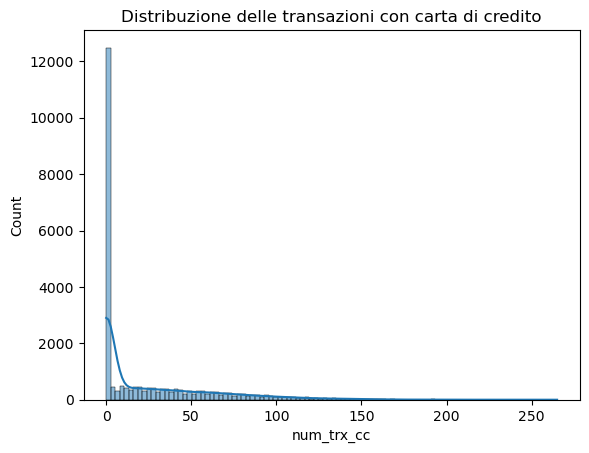

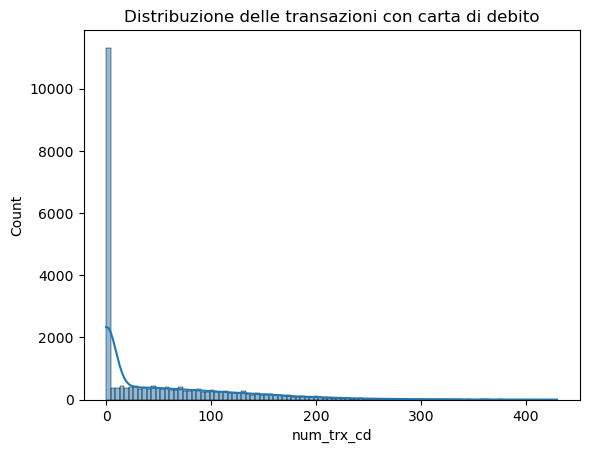

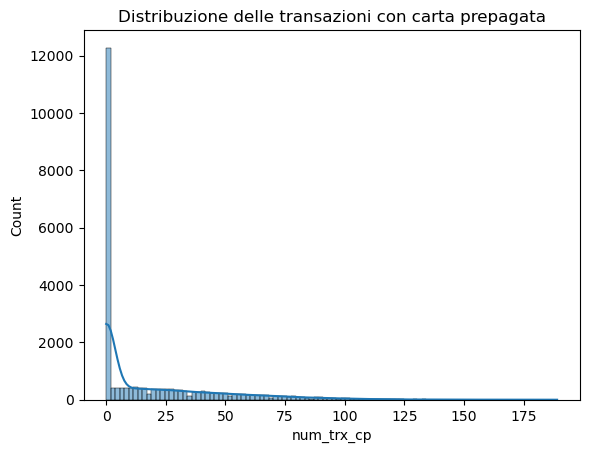

In [31]:
# Distribuzione numero di transizioni per le carte di credito:
sns.histplot(df['num_trx_cc'], kde=True, bins=100)
plt.title('Distribuzione delle transazioni con carta di credito')
plt.show()

# Distribuzione numero di transizioni per le carte di debito:
sns.histplot(df['num_trx_cd'], kde=True, bins=100)
plt.title('Distribuzione delle transazioni con carta di debito')
plt.show()

# Distribuzione numero di transizioni per le carte prepagate:
sns.histplot(df['num_trx_cp'], kde=True, bins=100)
plt.title('Distribuzione delle transazioni con carta prepagata')
plt.show()

- Le tre distribuzioni mi sembrano simili tra di esse. Sicuramente le carte di credito sono le maggiormente usate dai clienti, meno quelle prepagate. In generale la maggior parte dei clienti esegue un numero vicino all zero a prescindere dal tipo di carta utilizzata nel mese.

- Ora calcolo la correlazione tra le tre colonne e la variabile target:

In [32]:
df[['num_trx_cc', 'num_trx_cd', 'num_trx_cp', 'TARGET']].corr()

,num_trx_cc,num_trx_cd,num_trx_cp,TARGET
num_trx_cc,1.00000,0.00278,0.00218,-0.00023
num_trx_cd,0.00278,1.00000,-0.00384,-0.00019
num_trx_cp,0.00218,-0.00384,1.00000,-0.00255
TARGET,-0.00023,-0.00019,-0.00255,1.00000


- Le variabili transazionali non mostrano correlazioni lineari significative né tra loro né con il target. Tuttavia, questo non esclude che possano essere utili per il modello attraverso approcci non lineari (ad esempio, decision tree, gradient boosting, neural network).

- Ora mostro il numero di transazioni eseguite per tipo di carta per tipologia di cliente target:

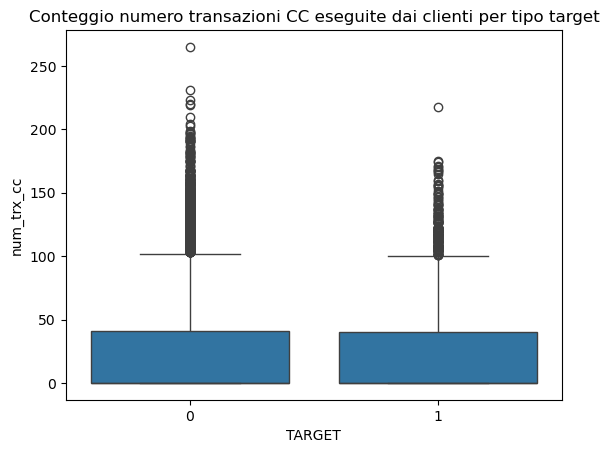

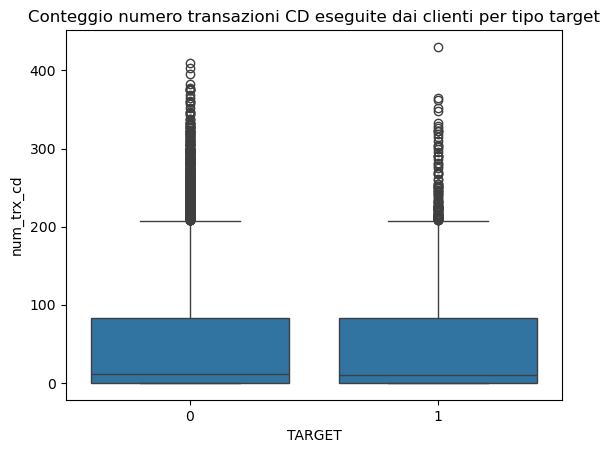

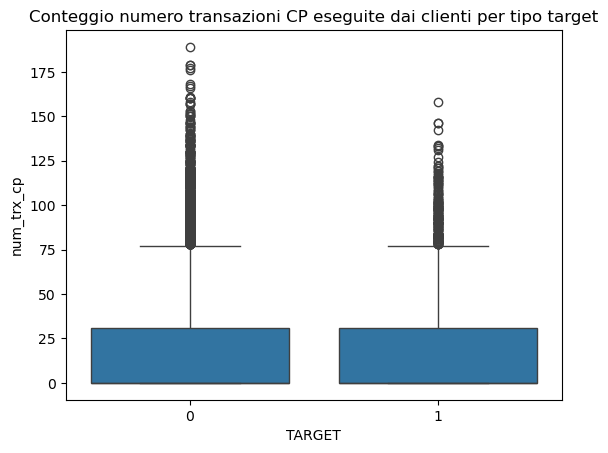

In [33]:
# Carta di credito:
sns.boxplot(data=df, x='TARGET', y='num_trx_cc')
plt.title('Conteggio numero transazioni CC eseguite dai clienti per tipo target')
plt.show()

# Carta di debito:
sns.boxplot(data=df, x='TARGET', y='num_trx_cd')
plt.title('Conteggio numero transazioni CD eseguite dai clienti per tipo target')
plt.show()

# Carta prepagata:
sns.boxplot(data=df, x='TARGET', y='num_trx_cp')
plt.title('Conteggio numero transazioni CP eseguite dai clienti per tipo target')
plt.show()

- Tutte e tre le figure mostrano come i clienti non frodatori eseguono un numero maggiore di transazioni al mese rispetto ai frodatori, a prescindere dal tipo di carta utilizzata.

- Successivamente creo una ulteriore colonna per individuare eventuali outliers presenti, calcolati con il metodo IsolationForest prendendo in considerazione le 4 colonne inerenti alle transizioni:

In [34]:
# Setto il parametro contamination:
contamination_parameter = 0.07

In [35]:
# Indico le colonne inerenti alle transizioni sulle quali calcolare gli outliers:
colonne_transazione = df[['num_trx_cc', 'num_trx_cd', 'num_trx_cp', 'num_trx_tot']]
iso = IsolationForest(contamination=contamination_parameter)
# Ora creo una nuova colonna mappata con i risultati del modello isolation forest, attraverso valori +1 / -1:
df['num_trx_sospette_outliers'] = iso.fit_predict(colonne_transazione)
# Mostro il numero di outliers individuati:
df['num_trx_sospette_outliers'].value_counts()

num_trx_sospette_outliers
 1    22354
-1     1683
Name: count, dtype: int64

- Sono stati individuati 1683 clienti con numero di transazioni eseguite sospette.
- Ora mostro con degli scatterplot le relative relazioni:

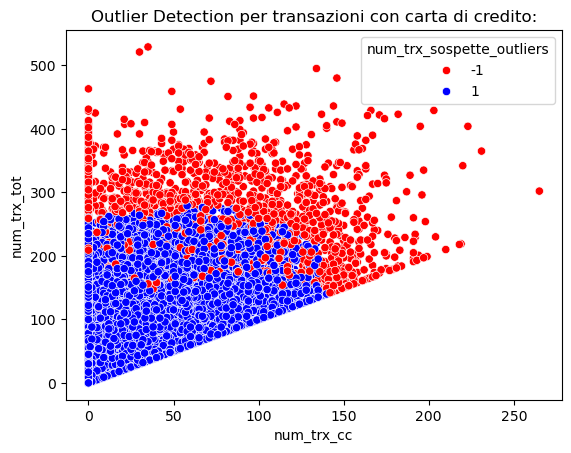

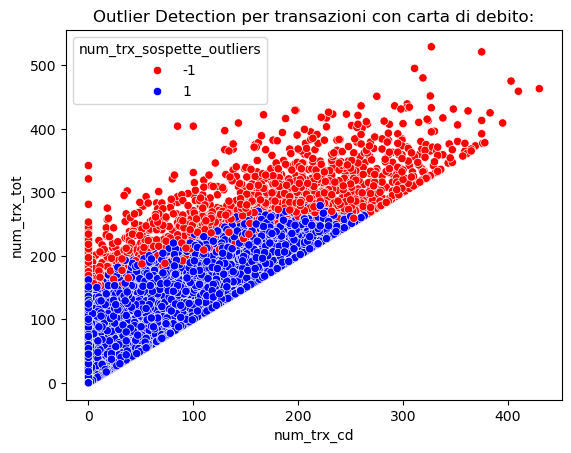

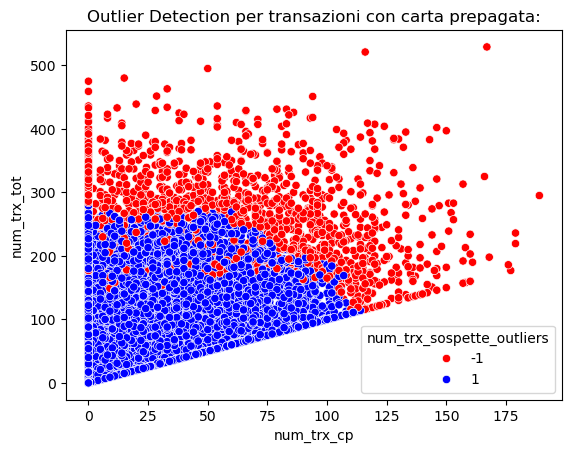

In [36]:
# Carta di credito:
sns.scatterplot(data=df, x='num_trx_cc', y='num_trx_tot', hue='num_trx_sospette_outliers', palette={1: 'blue', -1: 'red'})
plt.title('Outlier Detection per transazioni con carta di credito:')
plt.show()
# Carta di debito:
sns.scatterplot(data=df, x='num_trx_cd', y='num_trx_tot', hue='num_trx_sospette_outliers', palette={1: 'blue', -1: 'red'})
plt.title('Outlier Detection per transazioni con carta di debito:')
plt.show()
# Carta prepagata:
sns.scatterplot(data=df, x='num_trx_cp', y='num_trx_tot', hue='num_trx_sospette_outliers', palette={1: 'blue', -1: 'red'})
plt.title('Outlier Detection per transazioni con carta prepagata:')
plt.show()

- Intenzionalmente decido di lasciare tutti gli outliers presenti nel data frame in quanto esibiscono andamento sospetto in tutte e tre le visualizzazioni qui sopra.
    - Nello specifico, in tutte e tre, si vede una netta distinzione tra outliers e non outliers.
    - I clienti quindi individuati come anomali dal modello isolation forest sono ora identificati da una specifica colonna booleana +1 / -1.
    - Mi limito a trasformare i valori in formato 0 e 1:

In [37]:
df['num_trx_sospette_outliers'] = df['num_trx_sospette_outliers'].apply(lambda x: 1 if x == -1 else 0)

### num_mov_conto

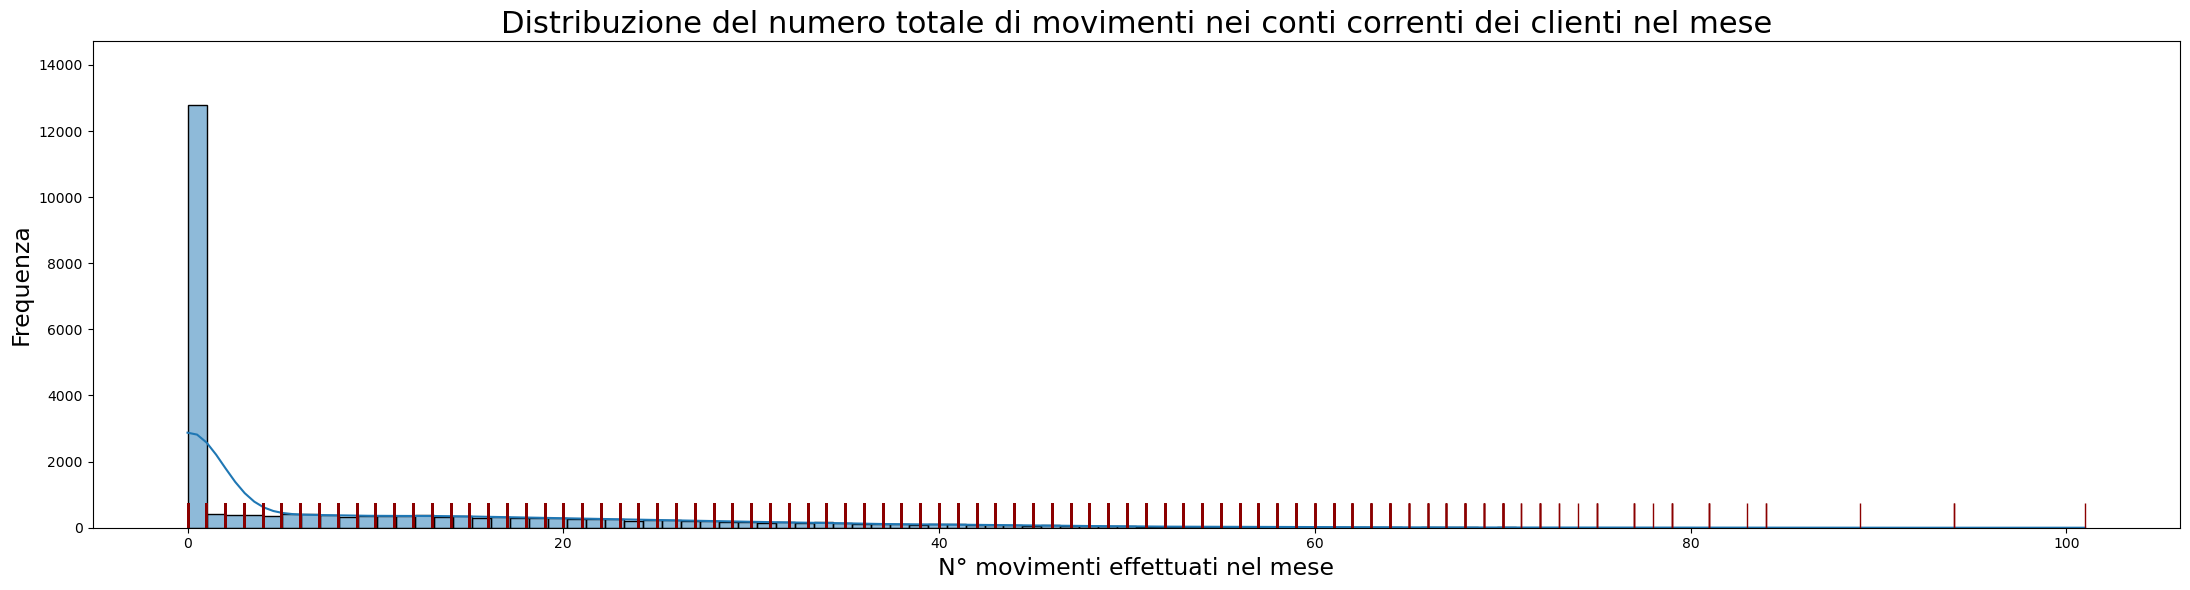

In [38]:
fig, (ax2) = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='num_mov_conto', bins=100, kde=True, ax=ax2)
sns.rugplot(data=df, x="num_mov_conto", height=.05, color="darkred")
ax2.set_title('Distribuzione del numero totale di movimenti nei conti correnti dei clienti nel mese', fontdict={'fontsize': 22})
ax2.set_xlabel('N° movimenti effettuati nel mese', fontsize=17)
ax2.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

- Anche in questo caso pare ci sia un alto numero di clienti che non ha effettuato alcun movimento nel mese, così come ci sia una ristretta quantità di clienti che invece ha effettuato un alto numero di movimenti all'interno del loro conto. creo quindi due colonne sulla base di queste osservazioni:

In [39]:
# Creo colonna booleana per identificare i clienti che non hanno movimenti nell'ultimo mese:
df['cliente_inattivo'] = (df['num_mov_conto'] == 0).astype(int)

# Creo una colonna booleana per tutti i clienti che hanno un numero molto alto di movimenti per mese:
df["num_mov_conto_eccessivi"] = (df["num_mov_conto"] >= 80).astype(int)

# Creo una colonna per definire la fascia di attività di movimenti effettuati dai clienti nei loro conti:
df['num_mov_conto_fascia'] = pd.cut(df['num_mov_conto'], bins=[-1, 10, 20, 40, 80, np.inf],labels=['Molto basso', 'Basso', 'Medio', 'Alto', 'Molto alto'])

# Creo colonne booleane partendo dalla colonna num_mov_conto_fascia:
encoder_5 = OneHotEncoder(sparse_output=False, dtype=int)
encoded_columns_5 = encoder_5.fit_transform(df[['num_mov_conto_fascia']])
encoded_df_5 = pd.DataFrame(encoded_columns_5, columns=encoder_5.get_feature_names_out(['num_mov_conto_fascia']), index=df.index, dtype=int)
df = df.join(encoded_df_5)

- Individuo eventuali outliers anche per la colonna numero movimento conto al fine di mappare una nuova variabile che identifichi clienti anomali sulla base del numero di movimenti effettuati nel mese, in quanto un alto numero di movimenti può simboleggiare un comportamento sospetto:

In [40]:
# Indico le colonne inerenti alle transizioni sulle quali calcolare gli outliers:
colonna_movimenti = df[['num_mov_conto']]
iso = IsolationForest(contamination=contamination_parameter)
# Ora creo una nuova colonna mappata con i risultati del modello isolation forest, attraverso valori +1 / -1:
df['num_mov_conto_sospette_outliers'] = iso.fit_predict(colonna_movimenti)
# Trasformo ora il formato +1 / -1 in formato 1 / 0:
df['num_mov_conto_sospette_outliers'] = df['num_mov_conto_sospette_outliers'].apply(lambda x: 1 if x == -1 else 0)
# Mostro il numero di outliers individuati:
df['num_mov_conto_sospette_outliers'].value_counts()

num_mov_conto_sospette_outliers
0    22392
1     1645
Name: count, dtype: int64

- Sono stati identificati in totale 1645 clienti che mostrano un numero di movimenti sul proprio conto nel mese descritti come sospetti dal modello isolation forest.

- Creo un'ulteriore colonna di analisi, dividendo il numero di movimenti effettuati diviso il totale delle transazioni per tipologia di carte, al fine di riscontrare dei valori ratio definibili in maniera sospetta, in quanto se nel caso ci fossero valori maggiori ad 1, potrebbe significare che Il cliente ha molti movimenti sul conto corrente rispetto al totale delle transazioni con le carte, quindi definibile come un comportamento sospetto.

In [41]:
df['movimenti_ratio'] = df['num_mov_conto'] / (df['num_trx_cd'] + df['num_trx_cc'] + df['num_trx_cp'] + 1)

- Mostro ora la distribuzione:

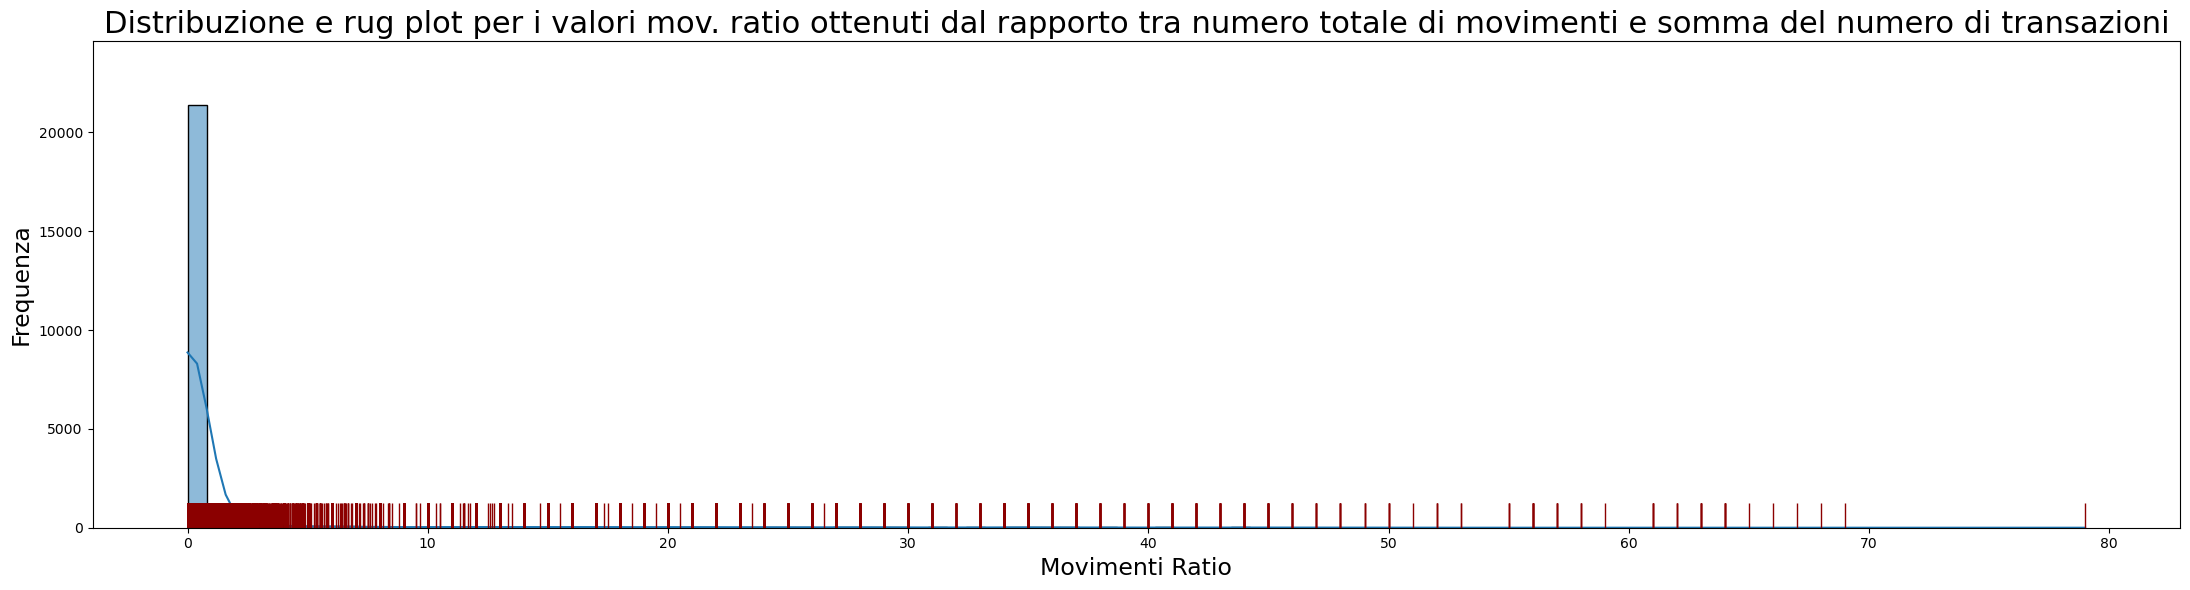

In [42]:
fig, (ax2) = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='movimenti_ratio', bins=100, kde=True, ax=ax2)
sns.rugplot(data=df, x="movimenti_ratio", height=.05, color="darkred")
ax2.set_title('Distribuzione e rug plot per i valori mov. ratio ottenuti dal rapporto tra numero totale di movimenti e somma del numero di transazioni',
              fontdict={'fontsize': 22})
ax2.set_xlabel('Movimenti Ratio', fontsize=17)
ax2.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

- Come visibile dal distribution rug plot, si evince che la maggior parte dei movimento ratio identificati è intorno a 1/2, tuttavia ci sono numerosi movimenti ration oltre 10 che sono decisamente sospetti.

### sum_mov_conto_pos & sum_mov_conto_neg

Ulteriormente, individuare la relazione con la variabile target, verificando se i clienti che commettono frodi hanno un comportamento diverso in termini di valori positivi e negativi di movimenti. Infine, calcolo la media di queste colonne separatamente per il gruppo fraudolento e non fraudolento. 

- Creo una nuova variabile ottenuta dalla differenza tra movimenti in entrata ed in uscita per ottenere il balancing tra le due variabili:

In [43]:
df["mov_conto_balance"] = df["sum_mov_conto_pos"] - df["sum_mov_conto_neg"]

- Ora creo invece un'ulteriore colonna che identifica se un cliente non ha movimenti ne in entrata ne in uscita:

In [44]:
df["mov_conto_pos_uguale_neg"] = ((df["sum_mov_conto_pos"] == 0) & (df["sum_mov_conto_neg"] == 0)).astype(int)

- Anche in questo caso con le colonne create e le due colonne neg e pos individuo eventuali outliers per quanto concerne la presenza di movimenti in entra o in uscita che rappresentano dei comportamenti anomali tra i clienti:

In [45]:
# Indico le colonne inerenti ai movimenti sulle quali calcolare gli outliers:
colonne_movimenti_pos_neg_bal = df[['sum_mov_conto_pos', 'sum_mov_conto_neg', 'mov_conto_balance']]
iso = IsolationForest(contamination=contamination_parameter)
# Ora creo una nuova colonna mappata con i risultati del modello isolation forest, attraverso valori +1 / -1:
df['mov_pos_neg_outliers'] = iso.fit_predict(colonne_movimenti_pos_neg_bal)
# Trasformo ora il formato +1 / -1 in formato 1 / 0:
df['mov_pos_neg_outliers'] = df['mov_pos_neg_outliers'].apply(lambda x: 1 if x == -1 else 0)
# Mostro il numero di outliers individuati:
df['mov_pos_neg_outliers'].value_counts()

mov_pos_neg_outliers
0    22354
1     1683
Name: count, dtype: int64

- Sono stati individuati 1683 clienti con comportamenti sospetti derivanti dal numero di movimenti sia positivi che negativi e dal loro balancing ottenuto.
    - Anche in questo caso gli outliers non saranno eliminati, anzi la colonna creata fungerà da variabile identificante un comportamento anomalo.

- Creo un ulteriore colonna ratio identificante il rapporto tra le uscite e le entrate, al fine di constatare se il rapporto identifica dei ratio particolarmente distanti dal valore 1:

In [46]:
df['ratio_neg_pos'] = df['sum_mov_conto_neg'] / (df['sum_mov_conto_pos'] + 1e-9)

- Successivamente intendo identificare tutti i clienti che hanno entrate molto, basse al mese, ovvero tra 0 e 100, identificando una quantità di soldi sospettosamente troppo bassa:

In [47]:
df["sum_pos_molto_basse"] = ((df["sum_mov_conto_pos"] >= 0) & (df["sum_mov_conto_pos"] <= 100)).astype(int)

- Visualizzo una eventuale relazione tra clienti che frodano e le relative uscite/entrate mensili:

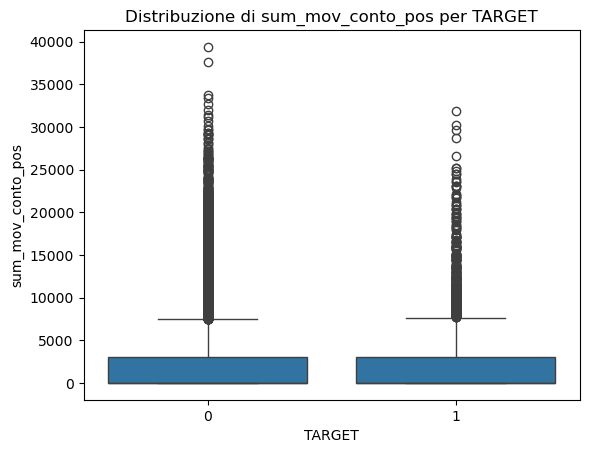

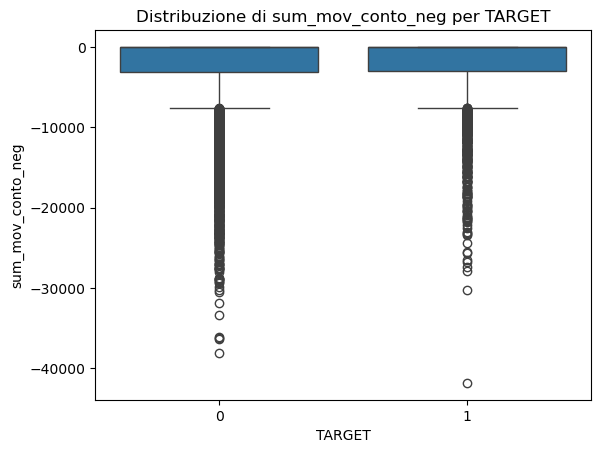

In [48]:
# Distribuzione per sum_mov_conto_pos
sns.boxplot(data=df, x='TARGET', y='sum_mov_conto_pos')
plt.title('Distribuzione di sum_mov_conto_pos per TARGET')
plt.show()

# Distribuzione per sum_mov_conto_neg
sns.boxplot(data=df, x='TARGET', y='sum_mov_conto_neg')
plt.title('Distribuzione di sum_mov_conto_neg per TARGET')
plt.show()

- Sia per i movimenti in entrata ed in uscita, i clienti che frodano mostrano una minore entità nelle due variabili relative alle somme di denaro in uscita e in entrata al mese.

### num_prodotti:

- individuo eventuali outliers. creo nuove colonne, suddividendo i clienti per target in base al numero complessivo di prodotti ad essi associati.

- Plotto la distribuzione del numero di prodotti per cliente:

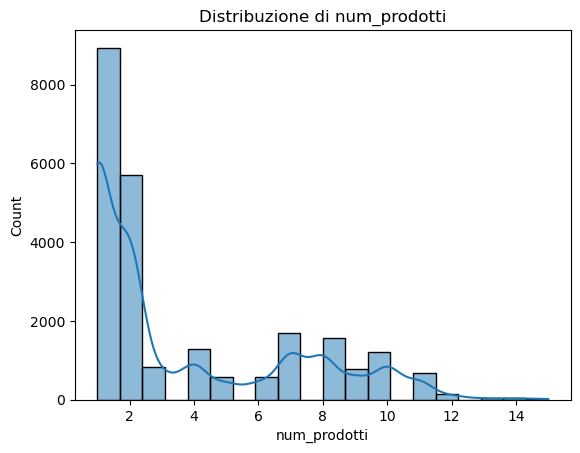

In [49]:
sns.histplot(df['num_prodotti'], bins=20, kde=True)
plt.title("Distribuzione di num_prodotti")
plt.show()

- La maggior parte dei clienti possiede 1 o 2 numero di prodotti in totale.
- La minoranza va oltre i 10 prodotti per cliente.

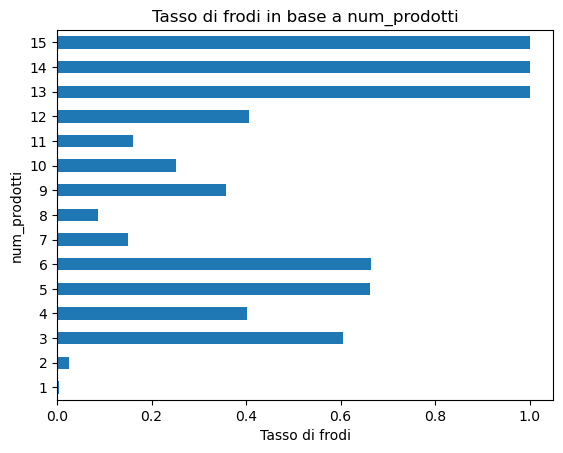

In [50]:
fraud_rate = df.groupby('num_prodotti')['TARGET'].mean()
fraud_rate.plot(kind='barh')
plt.title("Tasso di frodi in base a num_prodotti")
plt.xlabel("Tasso di frodi")
plt.show()

- I clienti con molti prodotti (13-14-15) mostrano un tasso di frodi molto alto, vicino al 100%. Questo potrebbe indicare un pattern specifico, come un comportamento sospetto legato a un numero insolitamente elevato di prodotti.

- A questo punto creo una serie di colonne booleane che servono per identificare le fasce di numero prodotti associati ai clienti:

In [51]:
# Creo una colonna cateforica rappresentante il numero di prodotti per cliente per fascia di appartenenza:
df['num_prodotti_fascia'] = pd.cut(df['num_prodotti'], bins=[0, 2, 4, 6, 8, float('inf')], labels=['1_2_prodotti', '3_4_prodotti', '5_6_prodotti', '7_8_prodotti', '9+_prodotti'])

# Creo colonne booleane partendo dalla colonna num_prodotti_fascia:
encoder_6 = OneHotEncoder(sparse_output=False, dtype=int)
encoded_columns_6 = encoder_6.fit_transform(df[['num_prodotti_fascia']])
encoded_df_6 = pd.DataFrame(encoded_columns_6, columns=encoder_6.get_feature_names_out(['num_prodotti_fascia']), index=df.index, dtype=int)
df = df.join(encoded_df_6)

- Scopro a questo punto con il test di significatività, la relazione tra la variabile target e il numero di prodotti:

In [52]:
contingency_table = pd.crosstab(df['num_prodotti'], df['TARGET'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("p-value:", p)

p-value: 0.0


- Un p-value basso (es. < 0.05) indica che le differenze tra i gruppi sono statisticamente significative.

- Infine, avendo scoperto la relazione tra il numero di prodotti e la variabile target ora mappo una nuova colonna in base al tasso di frodi per numero di prdotto:

In [53]:
# Calcolo la fraud rate per numero di prodotti associati ai singoli clienti:
fraud_rate = df.groupby('num_prodotti')['TARGET'].mean()
print(fraud_rate)
# Mappo una nuova colonna con la fraud rate associata in base al numero di prodotti:
df['fraud_rate_per_num_prod'] = df['num_prodotti'].map(fraud_rate)

num_prodotti
1    0.00347
2    0.02595
3    0.60558
4    0.40155
5    0.66195
6    0.66376
7    0.14940
8    0.08698
9    0.35844
10   0.25229
11   0.15970
12   0.40580
13   1.00000
14   1.00000
15   1.00000
Name: TARGET, dtype: float64


- Elimino le colonne che non servono piu all'interno del data frame finale:

In [54]:
# Elimino la colonna account balance macro:
df = df.drop(columns=['account_balance_macro'])
# Elimino la colonna region:
df = df.drop(columns=['region'])
# Elimino la colonna originale dal mio df:
df = df.drop(columns=['profession'])
# Elimino la colonna num_mov_conto_fascia:
df = df.drop(columns=['num_mov_conto_fascia'])
# Elimino la colonna num_prodotti_fascia:
df = df.drop(columns=['num_prodotti_fascia'])

### f2, f3, f4, f5, f6, f7

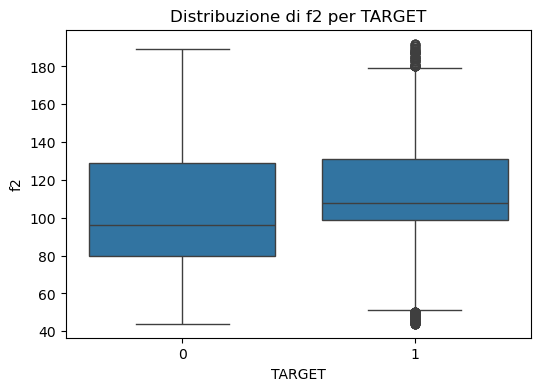

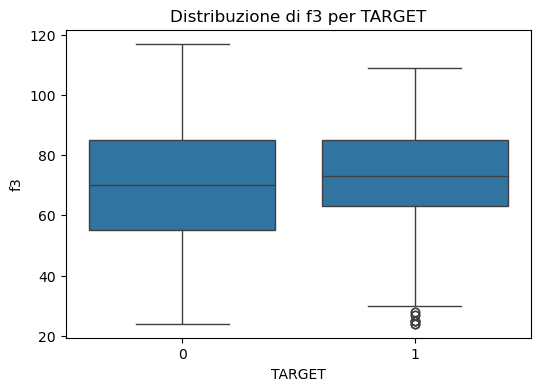

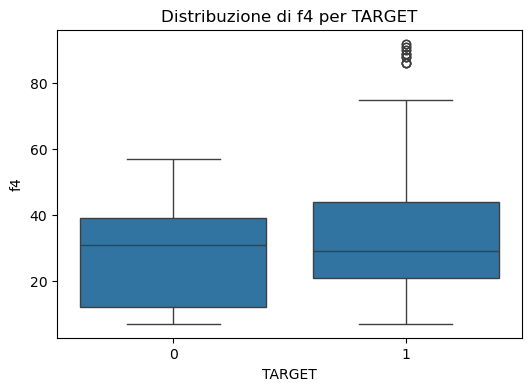

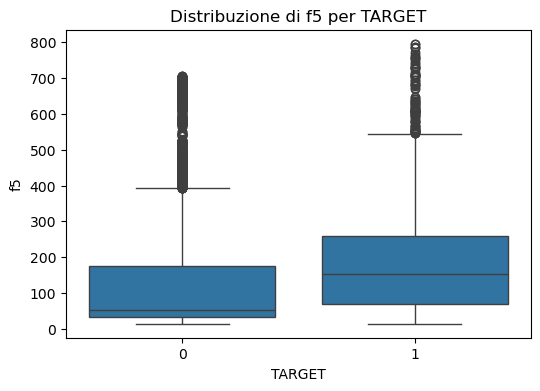

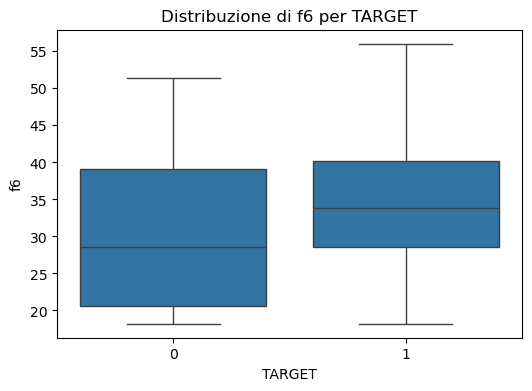

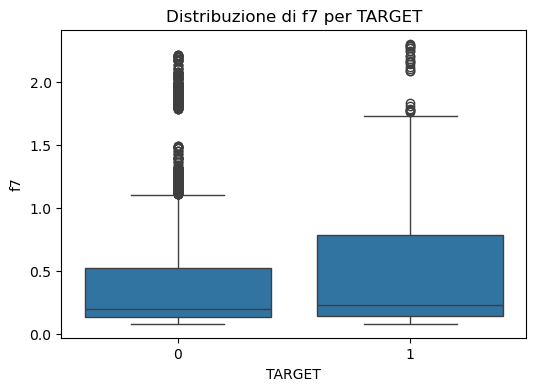

In [55]:
for col in ['f2', 'f3', 'f4', 'f5', 'f6', 'f7']:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='TARGET', y=col)
    plt.title(f"Distribuzione di {col} per TARGET")
    plt.show()

- Si evince da tutte le visualizzazioni che in generale, oer il target 1 di clienti, le variabili anonimizzate riportano valori piu alti rispetto al target 0. In special modo per la variabile f5 ed f6.


In [56]:
correlation = df[['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'TARGET']].corr()
print(correlation['TARGET'].sort_values(ascending=False))

TARGET   1.00000
f5       0.18859
f6       0.15035
f7       0.13167
f4       0.10685
f2       0.09296
f3       0.05911
Name: TARGET, dtype: float64


- Dal calcolo della correlazione, si evince che f5, f6, f7 ed f4 hanno una correlazione con la target variable relativamente significativa.
    - A dimostrazione del fatto che i boxplot mostrati qui sopra identificano una relazione importante tra distribuzione dei valori presenti in alcune delle colonne anonimizzate e la target variable.
 
- A questo punto decido di creare ulteriori variabili partendo dalle colonno anonimizzate.
    - Ritengo quindi importante creare due colonne basate sulla media e sulla standard deviation delle colonne anonimizzate in quanto descrivono un comportamento dei clienti, di conseguenza risulta importante poter avere a disposizone delle colonne che indichino variazioni comportamentali:

In [57]:
# La prima ottenuta con la media delle colonne anonimizzate comportamentali dei clienti:
df['colonne_f_mean'] = df[['f2', 'f3', 'f4', 'f5', 'f6', 'f7']].mean(axis=1)
# La seconda ottenuta con la standard deviation:
df['colonne_f_std'] = df[['f2', 'f3', 'f4', 'f5', 'f6', 'f7']].std(axis=1)

- Ora mostro la differenza di distribuzione delle colonne appena calcolate per tipologia di target:

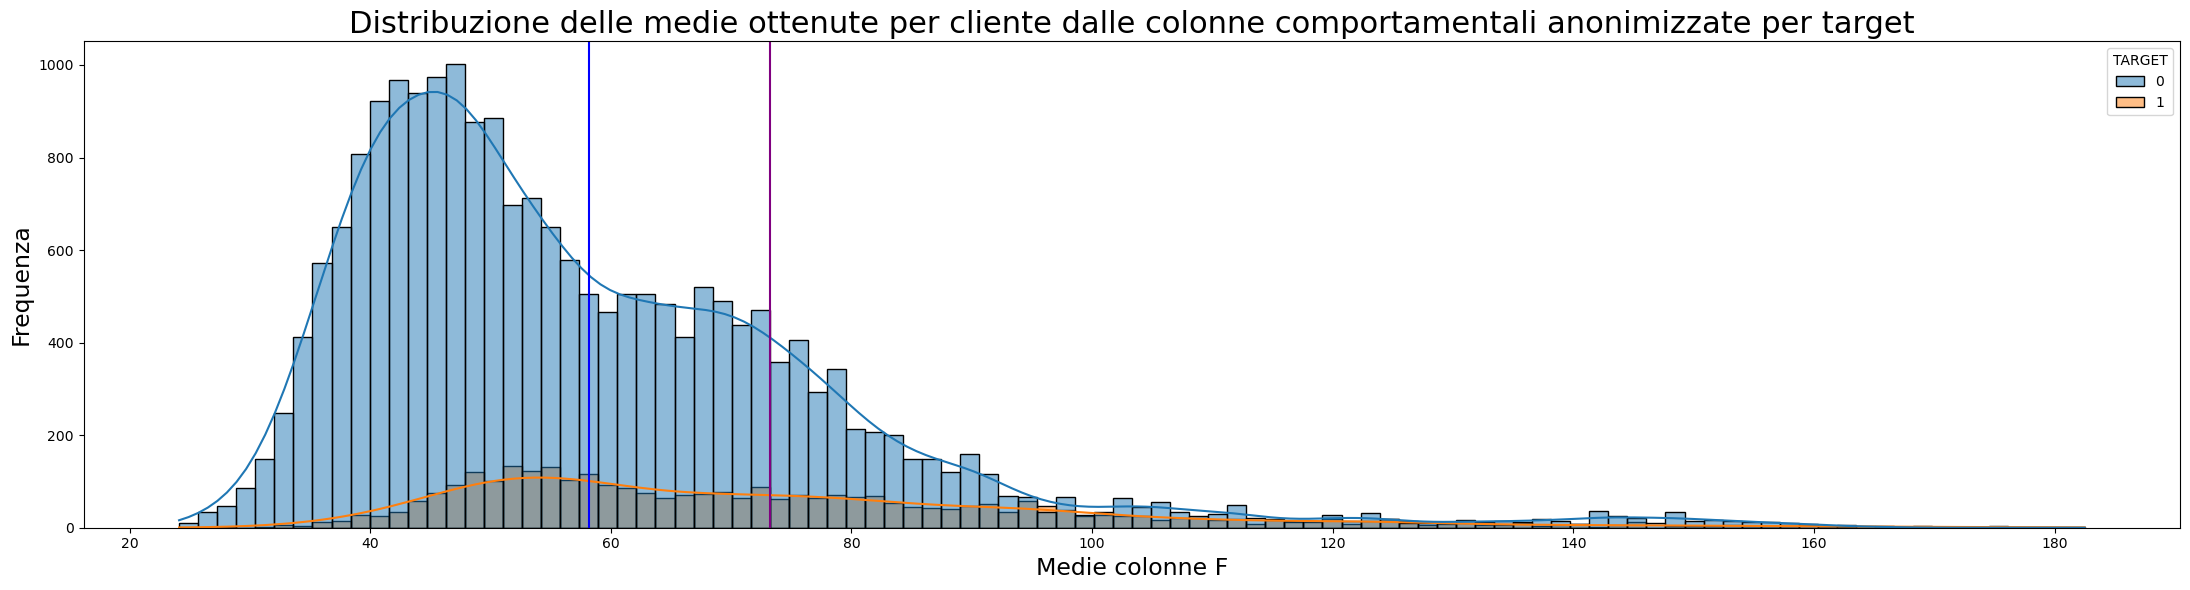

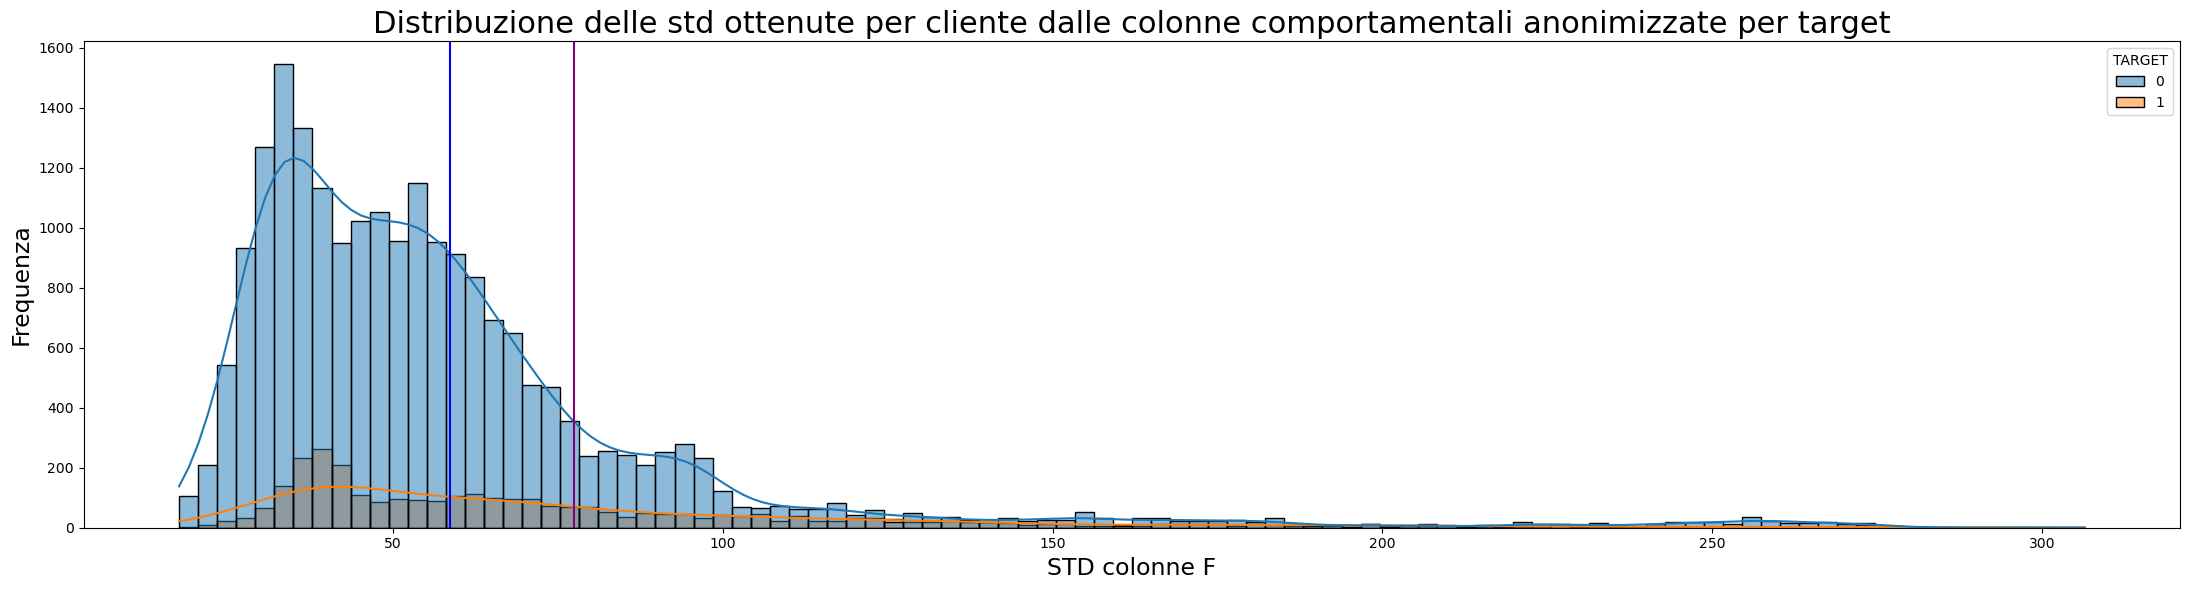

In [58]:
# Mostro la distribuzione delle medie per le colonne F tra diversi target:
fig, ax = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='colonne_f_mean', bins=100, kde=True, hue='TARGET', ax=ax)
media_f_0 = df[df["TARGET"] == 0]["colonne_f_mean"].mean()
media_f_1 = df[df["TARGET"] == 1]["colonne_f_mean"].mean()
ax.axvline(x= media_f_0, color='blue', linestyle='solid', label='5° percentile')
ax.axvline(x= media_f_1, color='purple', linestyle='solid', label='95° percentile')
ax.set_title('Distribuzione delle medie ottenute per cliente dalle colonne comportamentali anonimizzate per target', fontdict={'fontsize': 22})
ax.set_xlabel('Medie colonne F', fontsize=17)
ax.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

# Mostro la distribuzione delle STD per le colonne F tra diversi target:
fig, ax = plt.subplots(1, figsize=(22, 6))
sns.histplot(data=df, x='colonne_f_std', bins=100, kde=True, hue='TARGET', ax=ax)
media_f_0 = df[df["TARGET"] == 0]["colonne_f_std"].mean()
media_f_1 = df[df["TARGET"] == 1]["colonne_f_std"].mean()
ax.axvline(x= media_f_0, color='blue', linestyle='solid', label='5° percentile')
ax.axvline(x= media_f_1, color='purple', linestyle='solid', label='95° percentile')
ax.set_title('Distribuzione delle std ottenute per cliente dalle colonne comportamentali anonimizzate per target', fontdict={'fontsize': 22})
ax.set_xlabel('STD colonne F', fontsize=17)
ax.set_ylabel('Frequenza', fontsize=17)
plt.tight_layout()
plt.show()

- Esiste una netta distinzione tra le due medie. I clienti con TARGET 1, mostrano una media intorno a 70, mentre i clienti con target 0 mostrano unamedia intorno a 58. Stessa situazione per la standard deviation, che vede anche in questo caso, valori più alti complessivamente parlando per i clienti con target 1.

In [59]:
correlation = df[['colonne_f_mean', 'colonne_f_std', 'TARGET']].corr()
print(correlation['TARGET'].sort_values(ascending=False))

TARGET           1.00000
colonne_f_mean   0.23246
colonne_f_std    0.16337
Name: TARGET, dtype: float64


- Anche la correlazione tra target variable e le due colonne create identifica una discreta relazione tra le variabili.

In [60]:
# Indico le colonne comportamentali anonimizzate sulle quali calcolare gli outliers:
colonne_f = df[['f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'colonne_f_mean', 'colonne_f_std']]
iso = IsolationForest(contamination=contamination_parameter)
# Ora creo una nuova colonna mappata con i risultati del modello isolation forest, attraverso valori +1 / -1:
df['colonne_f_outliers'] = iso.fit_predict(colonne_f)
# Trasformo ora il formato +1 / -1 in formato 1 / 0:
df['colonne_f_outliers'] = df['colonne_f_outliers'].apply(lambda x: 1 if x == -1 else 0)
# Mostro il numero di outliers individuati:
df['colonne_f_outliers'].value_counts()

colonne_f_outliers
0    22355
1     1682
Name: count, dtype: int64

- Sono stati identificati circa 1683 outliers derivanti dalle colonne f e dalle derivate. Ora vediamo come la relativa distribuzione dei valori f medi tra outliers e non outliers appare:

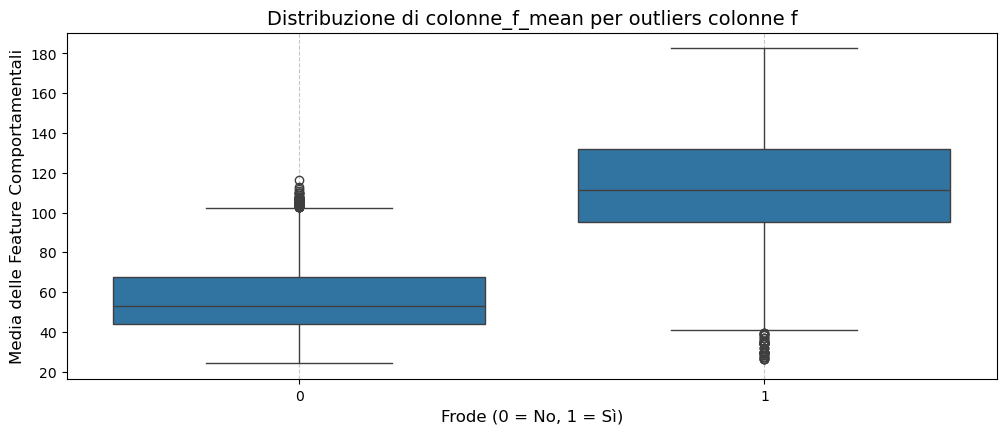

In [61]:
plt.figure(figsize=(12, 4.5))
sns.boxplot(data=df, x='colonne_f_outliers', y='colonne_f_mean')
plt.title("Distribuzione di colonne_f_mean per outliers colonne f", fontsize=14)
plt.xlabel("Frode (0 = No, 1 = Sì)", fontsize=12)
plt.ylabel("Media delle Feature Comportamentali", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

- Il grafico mostra una media ed una propensione a valori piu alti per gli outliers individuati grazie all'analisi condotta sulle colonne anonimizzate e le relative feature ricavate.
- Elimino dal modello l'ultima colonna che non serve, ovvero la colonna user id:

### Analisi del data frame finale: pulito, analizzato e pre processato:
- Sposto la target variable in prima posizone:

In [62]:
cols = list(df)
cols.insert(0, cols.pop(cols.index('TARGET')))
df = df.loc[:, cols]

- Elimino la user id column:

In [63]:
df = df.drop(columns=['userid'])

- Individuo dalle colonne finora ottenute, le coppie altamente correlate tra di esse.
    - Difatti, tra le altre conseguenze, due variabili troppo correlate tra di esse, possono provocare fenomeni di overfitting del modello.

In [64]:
# Calcolo della matrice di correlazione
correlation_matrix = df.corr().abs()
# Seleziona colonne con correlazione > 0.9
high_correlation_pairs = correlation_matrix.unstack().reset_index()
high_correlation_pairs.columns = ['Colonna_1', 'Colonna_2', 'Correlazione']
high_correlation_pairs = high_correlation_pairs[(high_correlation_pairs['Correlazione'] > 0.9) & (high_correlation_pairs['Colonna_1'] != high_correlation_pairs['Colonna_2'])]
high_correlation_pairs.reset_index(drop=True, inplace=True)
# Mostro le colonne che hanno esibito tra di esse una correlazione oltre 0.9:
display(high_correlation_pairs)

,Colonna_1,Colonna_2,Correlazione
0,sum_mov_conto_pos,mov_conto_balance,0.91908
1,sum_mov_conto_neg,mov_conto_balance,0.91850
2,f5,colonne_f_mean,0.95104
3,f5,colonne_f_std,0.95086
4,cliente_senza_reddito,cliente_con_reddito,1.00000
5,cliente_con_reddito,cliente_senza_reddito,1.00000
6,cliente_inattivo,mov_conto_pos_uguale_neg,1.00000
7,cliente_inattivo,sum_pos_molto_basse,0.97522
8,num_mov_conto_eccessivi,num_mov_conto_fascia_Molto alto,1.00000
9,num_mov_conto_fascia_Molto alto,num_mov_conto_eccessivi,1.00000


- Grazie alla funzione correlation.matrix sono state individuate le correlazioni tra le colonne del data frame. Tra esse vi sono differenti variabili che mostrano una correlazione rispettiva molto alta. Ho quindi inserito una soglia pari a 0.9 di valore correlazione al fine di selezionarle e salvarle in un data frame apposito al fine di utilizzarle poi per eliminarne solo una nel passaggio successivo, dove tengo solo una delle due colonne per singola coppia.

In [65]:
# Trovo le colonne altamente correlate (mantenendo solo una per ogni coppia)
columns_to_drop = set()
for Colonna_1, Colonna_2 in zip(high_correlation_pairs['Colonna_1'], high_correlation_pairs['Colonna_2']):
    if Colonna_1 not in columns_to_drop:
        columns_to_drop.add(Colonna_2)

# Mostro le colonne che andranno eliminate:
print("Colonne eliminate: \n ")
for i, col in enumerate(columns_to_drop, start=1):
    print(f"{i}. {col}")

Colonne eliminate: 
 
1. cliente_con_reddito
2. num_mov_conto_fascia_Molto alto
3. mov_conto_balance
4. sum_pos_molto_basse
5. colonne_f_std
6. mov_conto_pos_uguale_neg
7. colonne_f_mean


- Una volta identificate le colonne troppo correlate tra di esse e aver identificato quale delle due presenti nelle singole coppie da eliminare, le sottraggo al data frame finale:

In [66]:
# Elimina le colonne ridondanti
df = df.drop(columns=columns_to_drop)

#### Controllo la conformazione finale del data frame:
- Numero colonne e numero righe presenti:

In [67]:
df.shape

(24037, 81)

- Significa che ho eliminato dal data frame iniziale (24.987) in totale 950 osservazioni, pari a circa 3,8 % del totale iniziale.
- Ho creato in totale nel data frame finale 60 colonne, partendo da 20 iniziali.
- Controllo ora la costituzione delle singole colonne:

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24037 entries, 0 to 24036
Data columns (total 81 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   TARGET                                      24037 non-null  int64  
 1   age                                         24037 non-null  int64  
 2   account_balance                             24037 non-null  int32  
 3   num_trx_cd                                  24037 non-null  float64
 4   num_trx_cc                                  24037 non-null  float64
 5   num_trx_cp                                  24037 non-null  float64
 6   num_mov_conto                               24037 non-null  int32  
 7   sum_mov_conto_pos                           24037 non-null  int64  
 8   sum_mov_conto_neg                           24037 non-null  int64  
 9   num_prodotti                                24037 non-null  int64  
 10  f2        

- Tutte le colonne sono in formato integer o float. Non sono presenti timestamp, ID, object columns, come è giusto che sia in questo tipo di task di classificazione.

In [69]:
df.isnull().sum()

TARGET                                        0
age                                           0
account_balance                               0
num_trx_cd                                    0
num_trx_cc                                    0
num_trx_cp                                    0
num_mov_conto                                 0
sum_mov_conto_pos                             0
sum_mov_conto_neg                             0
num_prodotti                                  0
f2                                            0
f3                                            0
f4                                            0
f5                                            0
f6                                            0
f7                                            0
fascia_età_20-30                              0
fascia_età_31-40                              0
fascia_età_41-50                              0
fascia_età_51-60                              0
fascia_età_61-70                        

- Non sono piu presenti null values all'interno del data frame. 

#### Scaling del data frame finale: Solo le variabili indipendenti.
- Adotto MinMaxScaler in quanto:
    -  Scala i dati nel range [0, 1];
    -  E' sensibile agli outlier;
    -  Adotterò un modello **KNN** che è sensibile alle distanze.

In [70]:
# Togliere commento per test preliminare del modello
#df = df.head(1000) 

In [71]:
# Instanzio il modello per lo scaling delle variabili indipendenti rimaste:
scaler = MinMaxScaler()
# Instanzio le variabili X e y, contenenti le variabili indipendenti (da scalare) e quella dipendente (non da scalare):
X = df.drop(columns=['TARGET'])
y = df['TARGET']
# Scalo le variabili indipendenti presenti nel data frame X:
X  = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# Mostro la top 5 righe del data frame ottenuto:
X.head(5)

,age,account_balance,num_trx_cd,num_trx_cc,num_trx_cp,num_mov_conto,sum_mov_conto_pos,sum_mov_conto_neg,num_prodotti,f2,f3,f4,f5,f6,f7,fascia_età_20-30,fascia_età_31-40,fascia_età_41-50,fascia_età_51-60,fascia_età_61-70,fascia_età_70+,cliente_senza_reddito,profession_Imprenditore,profession_Lavoratore autonomo,profession_Lavoratore dipendente,profession_Non occupato,profession_Studente,region_ABRUZZO,region_BASILICATA,region_CALABRIA,region_CAMPANIA,region_EMILIA-ROMAGNA,region_FRIULI-VENEZIA GIULIA,region_LAZIO,region_LIGURIA,region_LOMBARDIA,region_MARCHE,region_MOLISE,region_PIEMONTE,region_PUGLIA,region_SARDEGNA,region_SICILIA,region_TOSCANA,region_TRENTINO-ALTO ADIGE,region_UMBRIA,region_VALLE AOSTA,region_VENETO,macro_zona_regione_Centro,macro_zona_regione_Isole,macro_zona_regione_Nord est,macro_zona_regione_Nord ovest,macro_zona_regione_Sud,account_balance_macro_Saldo_Molto_Negativo,account_balance_macro_Saldo_Molto_Positivo,account_balance_macro_Saldo_Negativo,account_balance_macro_Saldo_Positivo,num_trx_tot,transazioni_assenti,zero_trx_cc,zero_trx_cd,zero_trx_cp,num_trx_tot_eccessive,num_trx_sospette_outliers,cliente_inattivo,num_mov_conto_eccessivi,num_mov_conto_fascia_Alto,num_mov_conto_fascia_Basso,num_mov_conto_fascia_Medio,num_mov_conto_fascia_Molto basso,num_mov_conto_sospette_outliers,movimenti_ratio,mov_pos_neg_outliers,ratio_neg_pos,num_prodotti_fascia_1_2_prodotti,num_prodotti_fascia_3_4_prodotti,num_prodotti_fascia_5_6_prodotti,num_prodotti_fascia_7_8_prodotti,num_prodotti_fascia_9+_prodotti,fraud_rate_per_num_prod,colonne_f_outliers
0,0.03571,0.63882,0.00000,0.00000,0.00000,0.09901,0.09115,0.99115,0.07143,0.29730,0.38710,0.01176,0.00767,0.07773,0.08560,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.12658,0.00000,0.99978,1.00000,0.00000,0.00000,0.00000,0.00000,0.02256,0.00000
1,0.60714,0.58213,0.01628,0.00000,0.00000,0.00000,0.00000,1.00000,0.28571,0.35811,0.41935,0.04706,0.08696,0.52780,0.26751,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.01323,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.66077,0.00000
2,0.03571,0.41653,0.34419,0.00000,0.00000,0.01980,0.01615,0.99297,0.64286,0.31081,0.26882,0.28235,0.07289,0.53924,0.02190,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.27977,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00017,0.00000,0.99903,0.00000,0.00000,0.00000,0.00000,1.00000,0.24969,0.00000
3,0.39286,0.52721,0.50000,0.00000,0.00000,0.07921,0.02701,0.96079,0.14286,0.37162,0.45161,0.52941,0.05499,0.35166,0.90122,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.40643,0.00000,1.00000,0.00000,1.00000,0.00

# Training del modello - KNN

- Suddivido il data frame in train e test con una proporzione del 20%:

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

- Ora applico il metodo elbow al fine di predirre il miglior K Value per il data frame ottenuto al fine di predirre la target variable e mostro in un lineplot il K value che ha ottenuto l'error rate piu basso:

Error-Rate: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:28<00:00,  2.05it/s]


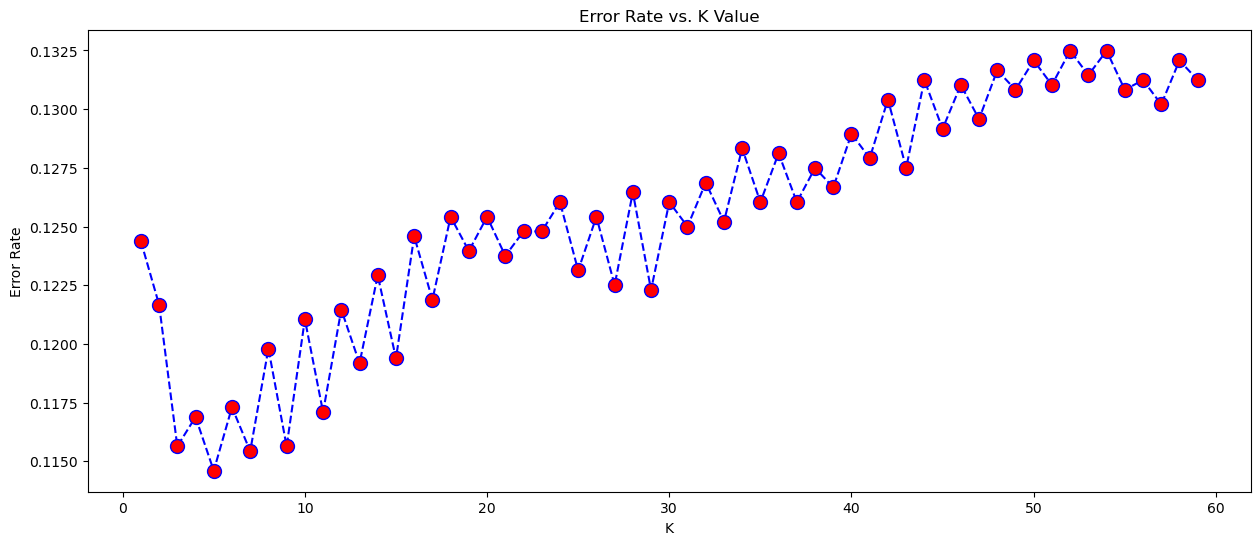

In [73]:
# Eseguo un for loop con 1 fino a 59 K Value:
error_rate = []
for i in tqdm(range(1, 60), desc="Error-Rate"):
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
# Mostro a questo punto attraverso un plot il parametro K Value che ha ottenuto le migliori performance: 
plt.figure(figsize=(15,6)) 
plt.plot(range(1,60), error_rate, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

- Una volta individuato il miglior parametro K Value, lo utilizzo per la fase predittiva con il modello KNN:

In [74]:
# Selezione automatica del miglior K value:
best_k = np.argmin(error_rate) + 1
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
Predictions_KNN = knn.predict(X_test)

# Mostro il K value individuato dal metodo elbow che ha espresso l'error rate più basso:
print(f"Best K Value: {best_k}")

Best K Value: 5


# Valutazione delle performance - KNN

In [75]:
# Creo a "confusion matrix" con le predizioni ottenute:
cm1 = confusion_matrix(y_test, Predictions_KNN)
# Importo in un data frame le predizioni corrette e quelle non corrette presenti nella confusion matrix per una visualizzazione migliore:
cm1 = pd.DataFrame(cm1, index=['No Fraud Target (actual)', 'Fraud Target (actual)'], columns = ['No Fraud Target (pred)', 'Fraud Target (pred)']) 

# Mostro la confusion matrix ottenuta:
print("\033[1;38;5;214m- Confusion Matrix:\n\033[0m")
display(cm1)
print("\n")

# Mostro il classification report ottenuto:
print("\033[1;38;5;214m- Classification Report:\n\033[0m")
print(classification_report(y_test, Predictions_KNN))

- Confusion Matrix:



,No Fraud Target (pred),Fraud Target (pred)
No Fraud Target (actual),4071,67
Fraud Target (actual),484,186




- Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      4138
           1       0.74      0.28      0.40       670

    accuracy                           0.89      4808
   macro avg       0.81      0.63      0.67      4808
weighted avg       0.87      0.89      0.86      4808



#### Interpretazione dei Risultati

- **Actual Negative (TN) = 4071:**
    
    - Il modello ha identificato correttamente 4071 clienti come non fraudolenti, corrispondenti ai casi in cui la predizione "No Fraud" è corretta.


- **False Positive (FP) = 67:**
    
    - Il modello ha classificato erroneamente 67 clienti come fraudolenti quando in realtà non lo erano.

- **False Negative (FN) = 484:**
    
    - Il modello ha classificato erroneamente 484 clienti fraudolenti come non fraudolenti.
    - Questo è il problema più grave, perché significa che quasi il 72% delle frodi reali (484 su 670) non vengono intercettate dal modello.


- **Actual Positive (TP) = 186:**
    
    - Il modello ha identificato correttamente 186 clienti fraudolenti, ovvero i casi in cui la predizione "Fraud" è corretta.
 
#### Conclusioni:
- Il modello funziona bene nell’identificare i clienti non fraudolenti, ma fallisce nell'intercettare un numero elevato di frodi.
- **Recall** per le frodi è basso (28%), il che significa che molte frodi sfuggono alla classificazione.
- **Accuracy** (89%) non è in questo caso una metrica valida per l'interpretazione del modello in quanto in dataset sbilanciati come questo, dove i non fraudolenti sono più numerosi ai fraudolenti, il modello per probabilità è comunque in grado di predirre correttamente la classe più rappresentata tra le osservazioni.

# Training del modello - Random Forest Classifier
- Provo ora con un secondo modello di classificazione, random forest classifier:

In [76]:
# Testo da 50 a 500 con step di 50
n_estimators_range = range(50, 501, 50)  
scores = {}
for n in tqdm(n_estimators_range):  
    rfc = RandomForestClassifier(n_estimators=n, random_state=101)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    scores[n] = accuracy_score(y_test, y_pred)  

# Trovo il valore di n_estimators con la miglior accuracy
best_n = max(scores, key=scores.get)
print(f"- Miglior numero di alberi: {best_n} con accuracy {scores[best_n]:.4f}")

# Addestro il modello con il miglior n_estimators
best_rfc = RandomForestClassifier(n_estimators=best_n, random_state=101)
best_rfc.fit(X_train, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.90s/it]


Miglior numero di alberi: 250 con accuracy 0.9559


RandomForestClassifier(n_estimators=250, random_state=101)

- Eseguo le predizioni con questo secondo modello per comparare poi le metriche di valutazioni ottenute rispetto a KNN Model:

In [78]:
Predictions_RFC = best_rfc.predict(X_test)

# Valutazione delle performance - Random Forest Classifier
- Calcolo le metriche di valutazione ottenute dalle predizioni con Random Forest Classifier:

In [79]:
# Creo a "confusion matrix" con le predizioni ottenute:
cm2 = confusion_matrix(y_test, Predictions_RFC)
# Importo in un data frame le predizioni corrette e quelle non corrette presenti nella confusion matrix per una visualizzazione migliore:
cm2 = pd.DataFrame(cm2, index=['No Fraud Target (actual)', 'Fraud Target (actual)'], columns = ['No Fraud Target (pred)', 'Fraud Target (pred)']) 

# Mostro la confusion matrix ottenuta:
print("\033[1;38;5;214m- Confusion Matrix:\n\033[0m")
display(cm2)
print("\n")

# Mostro il classification report ottenuto:
print("\033[1;38;5;214m- Classification Report:\n\033[0m")
print(classification_report(y_test, Predictions_RFC))

- Confusion Matrix:



,No Fraud Target (pred),Fraud Target (pred)
No Fraud Target (actual),4108,30
Fraud Target (actual),182,488




- Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4138
           1       0.94      0.73      0.82       670

    accuracy                           0.96      4808
   macro avg       0.95      0.86      0.90      4808
weighted avg       0.96      0.96      0.95      4808



#### Interpretazione dei Risultati

- **Actual Negative (TN) = 4108:**
    
    - Il modello ha identificato correttamente 4108 clienti come non fraudolenti, corrispondenti ai casi in cui la predizione "No Fraud" è corretta.


- **False Positive (FP) = 30:**
    
    - Il modello ha classificato erroneamente 30 clienti come fraudolenti quando in realtà non lo erano.


- **False Negative (FN) = 182:**
    
    - Il modello ha classificato erroneamente 182 clienti fraudolenti come non fraudolenti.
    - Questa è la metrica migliorata di più, perché significa che solo il 27% delle frodi reali (182 su 670) non vengono intercettate dal modello.


- **Actual Positive (TP) = 488:**
    
    - Il modello ha identificato correttamente 488 clienti fraudolenti, ovvero i casi in cui la predizione "Fraud" è corretta.
 
#### Conclusioni:
- Il modello funziona bene nell’identificare i clienti non fraudolenti, così come nell'identificare i clienti fraudolenti.
- **Recall** per le frodi è relativamente alto (73%), il che significa che molte frodi vengono effettivamente intercettate dalla classificazione.
- **Accuracy** (96%) non è in questo caso una metrica valida per l'interpretazione del modello in quanto in dataset sbilanciati come questo, dove i non fraudolenti sono più numerosi ai fraudolenti, il modello per probabilità è comunque in grado di predirre correttamente la classe più rappresentata tra le osservazioni. Tuttavia, rispetto a KNN, RFC ha migliorato ulteriormente di 7% l'accuracy score.